In [ ]:
#Создаём папку и __init__.py
!mkdir -p nowcast_lstm
!touch nowcast_lstm/__init__.py

#Перемещаем файлы
!mv LSTM.py nowcast_lstm/
!mv model_selection.py nowcast_lstm/
!mv data_setup.py nowcast_lstm/
!mv interval_prediction.py nowcast_lstm/
!mv mv_lstm.py nowcast_lstm/
!mv modelling.py nowcast_lstm/

!pip install pmdarima

!pip install --upgrade numpy==1.26.4 scipy==1.11.4 statsmodels==0.14.0 pmdarima==2.0.4

from pmdarima.arima import auto_arima
print("✅ pmdarima работает!")

#!pip install --upgrade tensorflow

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


mv: cannot stat 'LSTM.py': No such file or directory
mv: cannot stat 'model_selection.py': No such file or directory
mv: cannot stat 'data_setup.py': No such file or directory
mv: cannot stat 'interval_prediction.py': No such file or directory
mv: cannot stat 'mv_lstm.py': No such file or directory
mv: cannot stat 'modelling.py': No such file or directory
✅ pmdarima работает!


In [ ]:
from nowcast_lstm.LSTM import LSTM
from nowcast_lstm.model_selection import variable_selection, hyperparameter_tuning, select_model
import matplotlib.pyplot as plt
import pandas as pd
import torch
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# ФУНКЦИИ

In [ ]:
#!pip install tensorflow
import tensorflow as tf
def evaluate_lstm(data, test_start_date, test_end_date, hyper_params, target_variable, target_mean, target_std):
    target_variable = target_variable

    dates = (
        pd.date_range(test_start_date, test_end_date, freq="MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )
    #print(dates)
    test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)
    #print(test)
    actuals = list(test.loc[test.date.isin(dates), target_variable].values)
    #print(actuals)

    pred_dict = {k: [] for k in lags}
    for date in dates:
        train = test.loc[test.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=0))[:10],:]
        # print(train)
        model = LSTM(
        data = train,
        target_variable = target_variable,
        n_timesteps = hyper_params.get("n_timesteps"),
        fill_na_func = np.nanmean,
        fill_ragged_edges_func = np.nanmean,
        n_models = hyper_params.get("n_models"),
        train_episodes = hyper_params.get("train_episodes"),
        batch_size = hyper_params.get("batch_size"),
        decay = hyper_params.get("decay"),
        n_hidden = hyper_params.get("n_hidden"),
        n_layers = hyper_params.get("n_layers"),
        dropout = hyper_params.get("dropout"),
        criterion = torch.nn.MSELoss(), #здесь сделать rmse ~ равносильно
        optimizer = torch.optim.Adam, #здесь попробовать оптуну
        optimizer_parameters = hyper_params.get("optimizer_parameters") )
        model.train(quiet=True)

        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test, date, lag)
            pred = model.predict(data = tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
            pred = pred * target_std + target_mean
            pred_dict[lag].append(pred)

        actual_arr = np.array(actuals)
        actual_arr = actual_arr*target_std + target_mean

    performance = pd.DataFrame(columns=["Lag", "RMSE", "NRMSE"])
    hair_lengths = [6, 5, 4, 3, 2, 1]
    rmse_by_hair = {}
    nrmse_by_hair = {}
    std_test = actual_arr.std(ddof=0) # Считаем по всей выборке (N, а не N-1)
    #print(std_test)

    for hair in hair_lengths:
        rmse = []
        nmse = []
        max_start = len(actuals) - hair
        for start in range(max_start):
        # Истинные значения по траектории
             true = actual_arr[start : start + hair]
        # Прогнозы
             pred = []
             for lag in range(1, hair + 1):
                  pred.append(pred_dict[-lag][start + lag])
             pred = np.array(pred)

            # RMSE по одному волосу
             rmse_cur = np.sqrt(np.mean((true - pred) ** 2))
             rmse.append(rmse_cur)

            # усреднённый RMSE
        rmse_by_hair[hair] = np.mean(rmse)
        nrmse_by_hair[hair] = np.mean(rmse)/std_test

    performance = pd.DataFrame({
            "Lag": list(rmse_by_hair.keys()),
            "RMSE": list(rmse_by_hair.values()),
            "NRMSE": list(nrmse_by_hair.values())
        })

    print(performance.round(4))

    return actual_arr, pred_dict, dates


In [ ]:
def plot_lstm(actuals, pred, dates):
    predictions_elastic = pd.DataFrame({
            "six_back": pred[-6],
            "five_back": pred[-5],
            "four_back": pred[-4],
            "three_back": pred[-3],
            "two_back": pred[-2],
            "one_back": pred[-1],
            "actual": actuals
        }, index=dates)
    plt.figure(figsize=(12, 6))
    plt.plot(predictions_elastic.index, predictions_elastic["actual"],
                 label="Истинные значения", marker='o', linewidth=2, color='black')
    plt.plot(predictions_elastic.index, predictions_elastic["six_back"],
                 label="Прогноз (лаг -6)", marker='*', linestyle='--', linewidth=2)
    plt.plot(predictions_elastic.index, predictions_elastic["five_back"],
                 label="Прогноз (лаг -5)", marker='p', linestyle='--', linewidth=2)
    plt.plot(predictions_elastic.index, predictions_elastic["four_back"],
                 label="Прогноз (лаг -4)", marker='x', linestyle='--', linewidth=2)
    plt.plot(predictions_elastic.index, predictions_elastic["three_back"],
                 label="Прогноз (лаг -3)", marker='s', linestyle='--', linewidth=2)
    plt.plot(predictions_elastic.index, predictions_elastic["two_back"],
                 label="Прогноз (лаг -2)", marker='^', linestyle='--', linewidth=2)
    plt.plot(predictions_elastic.index, predictions_elastic["one_back"],
                 label="Прогноз (лаг -1)", marker='d', linestyle='--', linewidth=2)


    plt.title(f'Прогноз vs Истинные значения ({target_variable})')
    plt.xlabel('Дата')
    plt.ylabel(target_variable)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
#!pip install tensorflow
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.colors as colors

def plot_hair(actuals, pred, dates):
        predictions_df = pd.DataFrame({
            "six_back": pred[-6],
            "five_back": pred[-5],
            "four_back": pred[-4],
            "three_back": pred[-3],
            "two_back": pred[-2],
            "one_back": pred[-1],
            "actual": actuals
        }, index=pd.to_datetime(dates))

        plt.figure(figsize=(14, 8))

        # Основная линия истинных значений
        plt.plot(predictions_df.index, predictions_df["actual"],
                 label="Истинные значения", marker='o', linewidth=3, color='black', markersize=8, zorder=5)

        n_hairs = len(predictions_df) - 6
        cmap = cm.get_cmap("turbo")     # красивая яркая палитра
        norm = colors.Normalize(vmin=0, vmax=n_hairs - 1)

        for i in range(n_hairs):
            current_date = predictions_df.index[i]
            next_date_1  = predictions_df.index[i + 1]
            next_date_2  = predictions_df.index[i + 2]
            next_date_3  = predictions_df.index[i + 3]
            next_date_4  = predictions_df.index[i + 4]
            next_date_5  = predictions_df.index[i + 5]
            next_date_6  = predictions_df.index[i + 6]

            actual_val = predictions_df.iloc[i]["actual"]
            pred_1 = predictions_df.iloc[i + 1]["one_back"]
            pred_2 = predictions_df.iloc[i + 2]["two_back"]
            pred_3 = predictions_df.iloc[i + 3]["three_back"]
            pred_4 = predictions_df.iloc[i + 4]["four_back"]
            pred_5 = predictions_df.iloc[i + 5]["five_back"]
            pred_6 = predictions_df.iloc[i + 6]["six_back"]

            # Цвет для данного волоса
            color = cmap(norm(i))

            x_chain = [current_date, next_date_1, next_date_2, next_date_3,
                      next_date_4, next_date_5, next_date_6]
            y_chain = [actual_val, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6]

            plt.plot(x_chain, y_chain, color=color, linewidth=1.5, alpha=0.8)
            plt.scatter(x_chain[1:], y_chain[1:], color=color, s=50, alpha=0.9)

        plt.title(f'Волосатый график: цепочки прогнозов ({target_variable})', fontsize=14, fontweight='bold')
        plt.xlabel('Дата', fontsize=12)
        plt.ylabel(target_variable, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
#!pip install tensorflow
import tensorflow as tf
def nowcasting_lstm(data, test_start_date, test_end_date, hyper_params, target_variable, target_mean, target_std, plot):
    target_variable = target_variable

    dates = (
        pd.date_range(test_start_date, test_end_date, freq="MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )
    #print(dates)
    test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)
    #print(test)
    actuals = list(test.loc[test.date.isin(dates), target_variable].values)
    #print(actuals)
    actuals = np.array(actuals)*target_std + target_mean

    pred_dict = {k: [] for k in lags}
    for date in dates:
        train = test.loc[test.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=0))[:10],:]
        # print(train)
        model = LSTM(
        data = train,
        target_variable = target_variable,
        n_timesteps = hyper_params.get("n_timesteps"),
        fill_na_func = np.nanmean,
        fill_ragged_edges_func = np.nanmean,
        n_models = hyper_params.get("n_models"),
        train_episodes = hyper_params.get("train_episodes"),
        batch_size = hyper_params.get("batch_size"),
        decay = hyper_params.get("decay"),
        n_hidden = hyper_params.get("n_hidden"),
        n_layers = hyper_params.get("n_layers"),
        dropout = hyper_params.get("dropout"),
        criterion = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam,
        optimizer_parameters = hyper_params.get("optimizer_parameters") )
        model.train(quiet=True)

        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test, date, lag)
            pred = model.predict(data = tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
            pred = pred * target_std + target_mean
            pred_dict[lag].append(pred)

    performance = pd.DataFrame(columns=["Vintage", "RMSE", "MAE"])
    for lag in lags:
        tmp = pd.DataFrame({
            "Vintage":lag,
            "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
            "MAE":np.mean(np.abs((np.array(actuals) - np.array(pred_dict[lag]))))
        }, index=[0])
        performance = pd.concat([performance, tmp]).reset_index(drop=True)

    print(performance.round(4))

    if plot == 1:
        predictions_elastic = pd.DataFrame({
            "nowcasting": pred_dict[0],
            "actual": actuals
        }, index=dates)
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_elastic.index, predictions_elastic["actual"],
                 label="Истинные значения", marker='o', linewidth=2, color='black')
        plt.plot(predictions_elastic.index, predictions_elastic["nowcasting"],
                 label="Наукастинг (лаг 0)", marker='d', linestyle='--', linewidth=2)

        plt.title(f'Прогноз vs Истинные значения ({target_variable})')
        plt.xlabel('Дата')
        plt.ylabel(target_variable)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


KeyboardInterrupt: 

In [ ]:
#функция учитывающая лаги публикаций
#This function creates data vintages using a publication schedule, pub_lags vector, explained above, then generates predictions on these ragged datasets. The second parameter, lag, is the simulated period offset. It can be interpreted as the last period with full data relative to the target period. If we are nowcasting Q2, i.e. June, a lag of 0 simulates being in June. I.e. June is the last month with full data (for variables with lag 0). A lag of -1 simulates being in May, where May is the last full month. A lag of 1 simulates being in July, where variables with a lag of 1 now have June data as well. How many missings will be generated for a series can be calculated with -1*(lag - variable_pub_lag). E.g. we set the lagged period to -2 months back, and the variable has a 1 month publication lag, -1*(-2-1)=3, so the last three months will be set to missing. The data parameter should be passed the dataset to predict, if different from the dataset the model was trained on.
def gen_lagged_data(metadata, data, last_date, lag):
    # only go up to the last date
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] # publication lag of this particular variable
        # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back), also -1 because 0 lag means in month, last month data available, not current month in
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan
    return lagged_data

# helper function, flatten a dataset for methods that don't do timeseries, extra columns for each lag
def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")
    return flattened_data

# helper function fill missings in a dataset with the mean from the training set
def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

def fill_mean(df):
    df_filled = df.copy()
    numeric_columns = df_filled.select_dtypes(include='number').columns
    df_filled[numeric_columns] = df_filled[numeric_columns].fillna(df_filled[numeric_columns].mean())
    return df_filled

In [ ]:
#Стационарность
def check_stationarity(df, exclude_cols=None, alpha=0.05):

    numeric_cols = df.select_dtypes(include='number').columns
    cols_to_test = [col for col in numeric_cols if col not in exclude_cols]
    results = []

    for col in cols_to_test:
        series = df[col].dropna()
        adf_result = adfuller(series, autolag='AIC')
        p_value = adf_result[1]
        is_stationary = p_value < alpha
        conclusion = 'Стационарен' if is_stationary else 'Нестационарен'

        results.append([col, adf_result[0], p_value, conclusion])

    result_df = pd.DataFrame(
        results,
        columns=['Колонка', 'ADF-статистика', 'p-value', 'Вывод']
    )

    return result_df

def make_stationary(df, exclude_cols=None, alpha=0.05, max_diff=2):

    df_out = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns
    cols_to_process = [col for col in numeric_cols if col not in exclude_cols]

    for col in cols_to_process:
        series = df_out[col].dropna()
        adf_result = adfuller(series, autolag='AIC')
        p_value = adf_result[1]

        if p_value < alpha:
            print(f"✅ {col}: уже стационарен (p={p_value:.4f})")
            continue

        stationary = False
        diff_series = series.copy()

        for d in range(1, max_diff + 1):
            diff_series = diff_series.diff().dropna()
            if len(diff_series) < 10:
                break

            adf_result = adfuller(diff_series, autolag='AIC')
            p_value = adf_result[1]

            if p_value < alpha:
                print(f"✅ {col}: стационарен после {d} дифф. (p={p_value:.4f})")
                full_diff = df_out[col].diff(d)
                df_out[col] = full_diff
                stationary = True
                break

        if not stationary:
            print(f"⚠️  {col}: не удалось достичь стационарности за {max_diff} дифф.")

    return df_out


# Данные

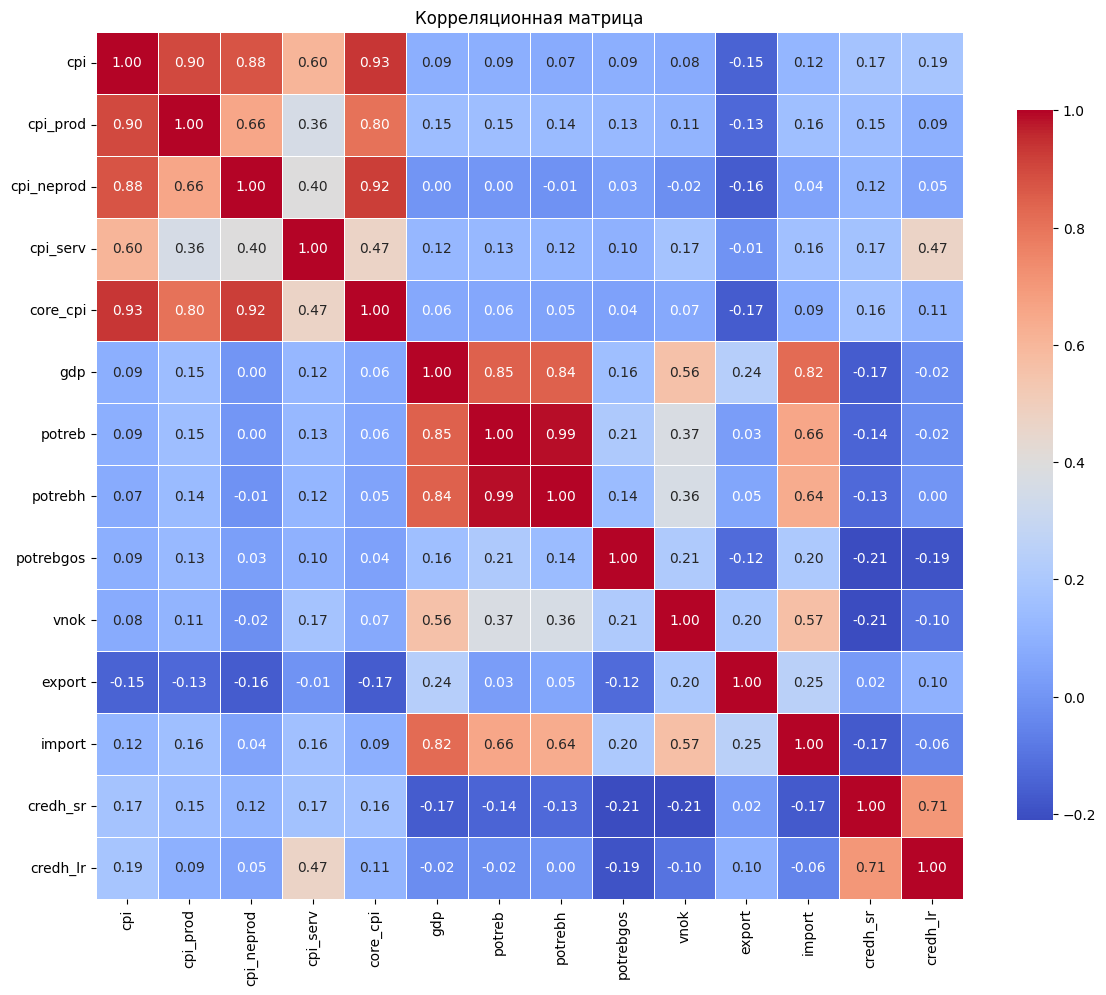

In [ ]:
data = pd.read_excel("dataset_full_1.xlsx", parse_dates=["date"])

df = pd.DataFrame(data[["cpi", "cpi_prod", "cpi_neprod", "cpi_serv", "core_cpi", "gdp", "potreb", "potrebh", "potrebgos", "vnok", "export", "import", "credh_sr", "credh_lr"]])

numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": .8},
    linewidths=0.5
)
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

In [ ]:
data.head()

date  credith_sec  mortgage_rub  potreb_rub       ort  ort_food  \
0 2002-01-01          NaN           NaN         NaN       NaN       NaN   
1 2002-02-01     4.540366           NaN         NaN  0.078068 -0.040262   
2 2002-03-01     1.095943           NaN         NaN -0.169949 -0.017009   
3 2002-04-01     2.183665           NaN         NaN  0.612201  0.803852   
4 2002-05-01     2.703055           NaN         NaN  0.022331 -0.433548   

   ort_nonfood       opu     cater       nzp  ...  ubk_h  nubk_h     usdrub  \
0          NaN       NaN       NaN       NaN  ...    NaN     NaN  30.472715   
1     0.186120  0.321637  1.162247  1.490038  ...    NaN     NaN  30.805700   
2    -0.307087 -0.172826 -0.696384  2.679441  ...    NaN     NaN  31.064267   
3     0.437891  0.793478  1.729560  1.818858  ...    NaN     NaN  31.173586   
4     0.435583  0.559453 -0.010869  1.795317  ...    NaN     NaN  31.254884   

   urals  housetwomosc  housetworus  houseonemosc  houseonerus  d_mortgage  \
0    NaN           NaN          NaN           NaN          NaN         0.0   
1    NaN           NaN          NaN           NaN          NaN         0.0   
2    NaN       9436.85     19403.79       9921.52     17768.39         0.0   
3    NaN           NaN          NaN           NaN          NaN         0.0   
4    NaN           NaN          NaN           NaN          NaN         0.0   

   d_mortgage0  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 52 columns]

In [ ]:
#Стандартизация
scaler = StandardScaler()

credith_mean = data['credith_sec'].mean()
credith_std = data['credith_sec'].std()
mortgage_mean = data['mortgage_rub'].mean()
mortgage_std = data['mortgage_rub'].std()
potreb_mean = data['potreb_rub'].mean()
potreb_std = data['potreb_rub'].std()


data_fill = fill_mean(data)
df_normalized = data_fill.copy()
exclude_columns = ['date', 'd_mortgage', 'd_mortgage0']

columns_to_normalize = [
    col for col in df_normalized.select_dtypes(include='number').columns
    if col not in exclude_columns]

df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])

data = df_normalized

In [ ]:
data.head()

date  credith_sec  mortgage_rub    potreb_rub       ort  ort_food  \
0 2002-01-01     0.000000           0.0  9.975582e-17  0.000000  0.000000   
1 2002-02-01     0.976473           0.0  9.975582e-17 -0.136847 -0.249470   
2 2002-03-01    -0.486701           0.0  9.975582e-17 -0.244867 -0.231791   
3 2002-04-01    -0.024642           0.0  9.975582e-17  0.095785  0.392316   
4 2002-05-01     0.195992           0.0  9.975582e-17 -0.161123 -0.548489   

    ort_nonfood       opu     cater       nzp  ...         ubk_h  \
0 -3.178938e-17  0.000000  0.000000  0.000000  ... -7.010117e-17   
1 -9.178518e-02  0.012678  0.129169  0.272182  ... -7.010117e-17   
2 -2.330068e-01 -0.184056 -0.286776  1.181438  ... -7.010117e-17   
3 -1.969467e-02  0.200412  0.256129  0.523553  ... -7.010117e-17   
4 -2.035553e-02  0.107299 -0.133364  0.505557  ... -7.010117e-17   

         nubk_h    usdrub  urals  housetwomosc   housetworus  houseonemosc  \
0  4.655113e-17 -0.813077    0.0      0.000000  7.208783e-16 -3.428231e-16   
1  4.655113e-17 -0.798223    0.0      0.000000  7.208783e-16 -3.428231e-16   
2  4.655113e-17 -0.786689    0.0     -3.077323 -3.144974e+00 -2.284521e+00   
3  4.655113e-17 -0.781812    0.0      0.000000  7.208783e-16 -3.428231e-16   
4  4.655113e-17 -0.778186    0.0      0.000000  7.208783e-16 -3.428231e-16   

    houseonerus  d_mortgage  d_mortgage0  
0 -3.331273e-16         0.0          0.0  
1 -3.331273e-16         0.0          0.0  
2 -2.440927e+00         0.0          0.0  
3 -3.331273e-16         0.0          0.0  
4 -3.331273e-16         0.0          0.0  

[5 rows x 52 columns]

In [ ]:
#Переход к стационарным
results = check_stationarity(data, exclude_cols=['date'])
print(results)
df_stationary = make_stationary(data, exclude_cols=['date', 'ofz1', 'ofz2', 'ofz3', 'ofz5', 'ofz10', 'credh_sr', 'credh_lr', 'miacr', 'mrtg', 'd_mortgage', 'd_mortgage0'])
results = check_stationarity(df_stationary, exclude_cols=['date'])
print(results)
data = df_stationary

         Колонка  ADF-статистика       p-value          Вывод
0    credith_sec       -3.702268  4.081372e-03    Стационарен
1   mortgage_rub       -4.947930  2.810814e-05    Стационарен
2     potreb_rub       -3.110887  2.575792e-02    Стационарен
3            ort      -14.028015  3.475110e-26    Стационарен
4       ort_food       -7.059984  5.254126e-10    Стационарен
5    ort_nonfood      -14.403497  8.432193e-27    Стационарен
6            opu      -12.257653  9.231588e-23    Стационарен
7          cater       -9.728137  9.156530e-17    Стационарен
8            nzp       -2.636339  8.571686e-02  Нестационарен
9            rzp       -3.437152  9.755713e-03    Стационарен
10           oot      -16.849870  1.120882e-29    Стационарен
11          stro       -3.759404  3.351076e-03    Стационарен
12        houses       -4.728902  7.423858e-05    Стационарен
13         u_lvl       -8.845787  1.622184e-14    Стационарен
14    unemployed       -8.825804  1.825032e-14    Стационарен
15      

In [ ]:
# мы можем настраивать гиперпараметры
help(hyperparameter_tuning)

# а можем выбирать значимые переменные
help(variable_selection)

# а можем и то и другое
help(select_model)

Help on function hyperparameter_tuning in module nowcast_lstm.model_selection:

hyperparameter_tuning(data, target_variable, n_models=1, n_timesteps_grid=[6, 12], fill_na_func_grid=[<function nanmean at 0x7c166d55fdb0>], fill_ragged_edges_func_grid=[<function nanmean at 0x7c166d55fdb0>], train_episodes_grid=[50, 100, 200], batch_size_grid=[30, 100, 200], decay_grid=[0.98], n_hidden_grid=[10, 20, 40], n_layers_grid=[1, 2, 4], dropout_grid=[0], criterion_grid=[''], optimizer_grid=[''], optimizer_parameters_grid=[{'lr': 0.01}], n_folds=1, init_test_size=0.2, pub_lags=[], lags=[], performance_metric='RMSE', quiet=False)
    Pick best-performing hyperparameters for a given dataset. n_timesteps_grid has default grid for predicting quarterly variable with monthly series, may have to change per use case. E.g. [12,24] for a yearly target with monthly indicators.

    parameters:
        All parameters up to `optimizer_parameters` exactly the same as for any LSTM() model, provide a list with the

## **ПЕРЕМЕННАЯ CREDITH_SEC**

In [ ]:
target_variable = "credith_sec"
data_cr = data[["date", target_variable, "ort", "ort_food", "ort_nonfood", "opu", "cater", "nzp", "rzp", "oot", "stro", "houses", "u_lvl", "unemployed", "l_dem", "consump", "pmi_mnf", "pmi_serv", "pmi_comp", "cpi", "cpi_prod", "cpi_neprod", "cpi_serv", "core_cpi", "gdp", "potreb", "potrebh", "potrebgos", "vnok", "export", "import", "credh_sr", "credh_lr", "miacr", "ofz1", "ofz2", "ofz3", "ofz5", "ofz10", "mrtg", "ubk_h", "nubk_h", "usdrub", "urals", "housetwomosc", "housetworus", "houseonemosc", "houseonerus", "d_mortgage"]]

columns = data_cr.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in data_cr.columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date
lags = list(range(-6, 0)) #прогнозируем от одного до шести месяцев
# train and test dates
train_start_date = "2002-03-01"
train_end_date = "2022-12-01"
test_start_date = "2023-01-01"
test_end_date = "2025-08-01"

# train and test datasets
test = data_cr.loc[(data_cr.date >= train_start_date) & (data_cr.date <= test_end_date), :].reset_index(drop=True)

# Смешанный способ настройки гиперпараметров

In [ ]:
train = data_cr.loc[(data_cr.date >= train_start_date) & (data_cr.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_cr.loc[(data_cr.date >= train_start_date) & (data_cr.date <= test_end_date), :].reset_index(drop=True)

#Здесь попробовать разреженную сетку????
#performance1 = hyperparameter_tuning(data, target_variable, n_timesteps_grid=[12], n_hidden_grid=[10,20], performance_metric='RMSE')
#performance1 = hyperparameter_tuning(data, target_variable, n_models=10, n_timesteps_grid = [6, 12], train_episodes_grid = [100, 200], batch_size_grid = [30], n_hidden_grid = [10, 20], n_layers_grid = [2], n_folds=2)

# hyperparameter and variable selection
# checking on artificial vintages with made up publication lags, two months before, month of, and 2 months after vintages
selection_results = select_model(train, target_variable, n_timesteps_grid = [12], n_hidden_grid = [10, 20], performance_metric="RMSE", lags = [-3, -2, -1])

In [ ]:
#отобранные переменные
selection_results.iloc[0,0]

['credh_lr', 'rzp', 'vnok', 'potrebgos', 'export']

In [ ]:
#настройки сети
hyperparamets1 = selection_results.iloc[0,1]
print(hyperparamets1)
#{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7fa1bef23170>, 'fill_ragged_edges_func': <function nanmean at 0x7fa1bef23170>, 'train_episodes': 200, 'batch_size': 50, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}

{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a20d69696f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a20d69696f0>, 'train_episodes': 200, 'batch_size': 50, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}


In [ ]:
data_cut = data_cr[['date', target_variable, 'credh_lr', 'rzp', 'vnok', 'potrebgos', 'export']]

columns = data_cut.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals1, pred1, dates1 = evaluate_lstm(data_cut, test_start_date, test_end_date, hyperparamets1, target_variable, credith_mean, credith_std)

/tmp/ipython-input-2215130985.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  0.6806  0.7891
1    5  0.6226  0.7218
2    4  0.5655  0.6556
3    3  0.4720  0.5473
4    2  0.4232  0.4907
5    1  0.3501  0.4059


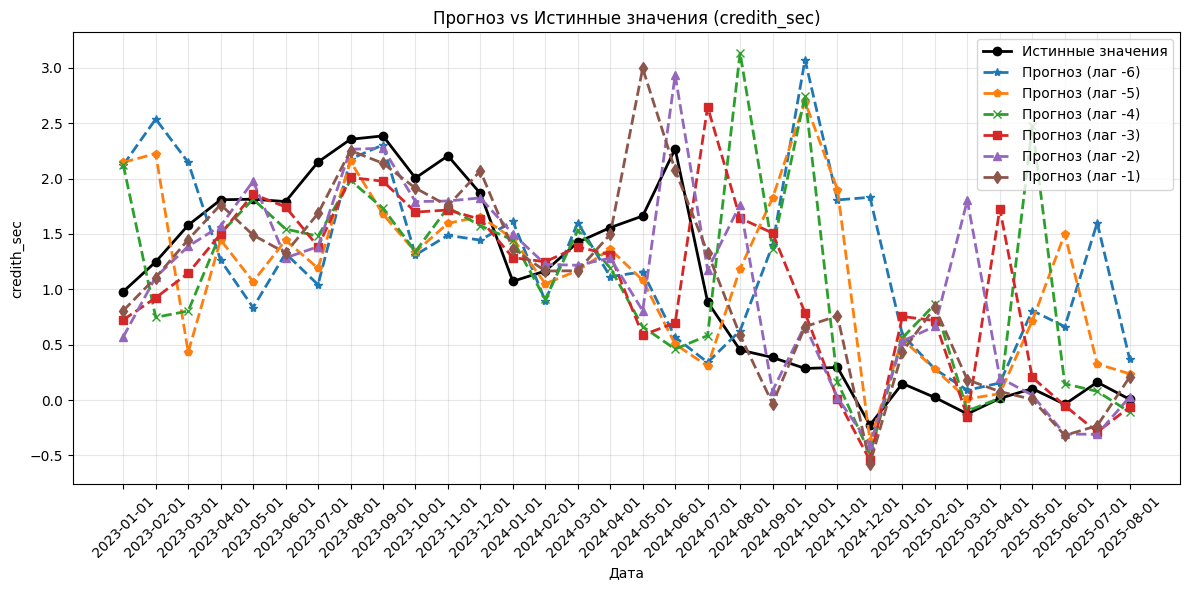

None


In [ ]:
print(plot_lstm(actuals1, pred1, dates1))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


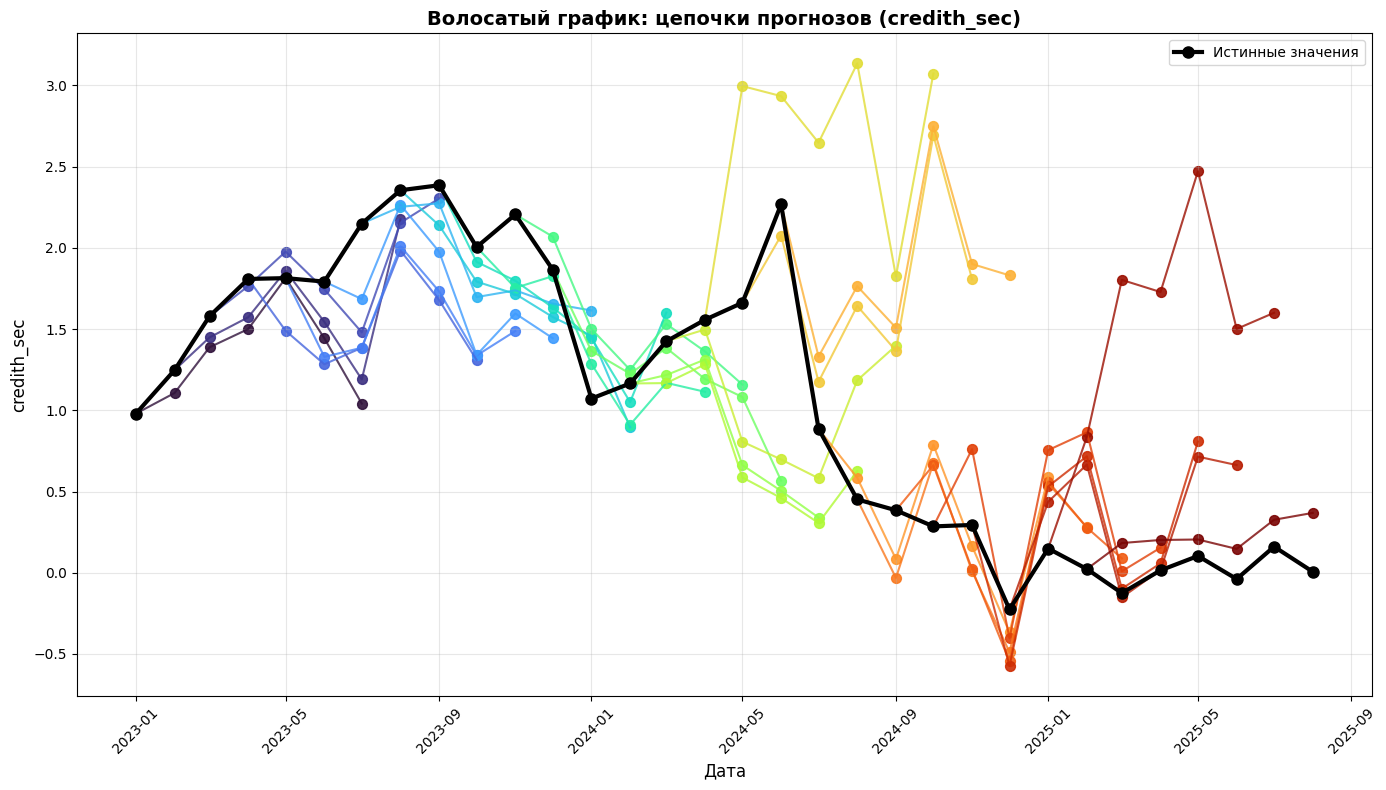

None


In [ ]:
print(plot_hair(actuals1, pred1, dates1))

# С частью переменных

In [ ]:
data_cut2 = data_cr[["date", target_variable, 'consump',
 'u_lvl',
 'gdp',
 'potrebh',
 'miacr',
 'ofz5',
 'credh_sr',
 'credh_lr',
 'usdrub',
 'urals',
 'rzp']]

columns = data_cut2.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
train = data_cut2.loc[(data_cut2.date >= train_start_date) & (data_cut2.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_cut2.loc[(data_cut2.date >= train_start_date) & (data_cut2.date <= test_end_date), :].reset_index(drop=True)

In [ ]:
hyperparamets2 = hyperparameter_tuning(train, target_variable, n_timesteps_grid=[6], n_hidden_grid=[10,20], performance_metric='RMSE')
hyperparamets2 = hyperparamets2["hyper_params"][0]
#performance1 = hyperparameter_tuning(data, target_variable, n_models=10, n_timesteps_grid = [6, 12], train_episodes_grid = [100, 200], batch_size_grid = [30], n_hidden_grid = [10, 20], n_layers_grid = [2], n_folds=2)

In [ ]:
hyperparamets2 = {'n_models': 1,
 'n_timesteps': 12,
 'fill_na_func': np.nanmean,
 'fill_ragged_edges_func': np.nanmean,
 'train_episodes': 200,
 'batch_size': 30,
 'decay': 0.98,
 'n_hidden': 10,
 'n_layers': 4,
 'dropout': 0,
 'criterion': '',
 'optimizer': '',
 'optimizer_parameters': {'lr': 0.01}}

#  {'n_models': 1,
#  'n_timesteps': 12,
#  'fill_na_func': <function nanmean at 0x7a766741f930>,
#  'fill_ragged_edges_func': <function nanmean at 0x7a766741f930>,
#  'train_episodes': 200,
#  'batch_size': 30,
#  'decay': 0.98,
#  'n_hidden': 10,
#  'n_layers': 4,
#  'dropout': 0,
#  'criterion': '',
#  'optimizer': '',
#  'optimizer_parameters': {'lr': 0.01}}

In [ ]:
pip install --upgrade sympy

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals2, pred2, dates2 = evaluate_lstm(data_cut2, test_start_date, test_end_date, hyperparamets2, target_variable,  credith_mean, credith_std)

/tmp/ipython-input-1388537349.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  0.6852  0.7944
1    5  0.6166  0.7149
2    4  0.5364  0.6219
3    3  0.4438  0.5145
4    2  0.3608  0.4183
5    1  0.2371  0.2749


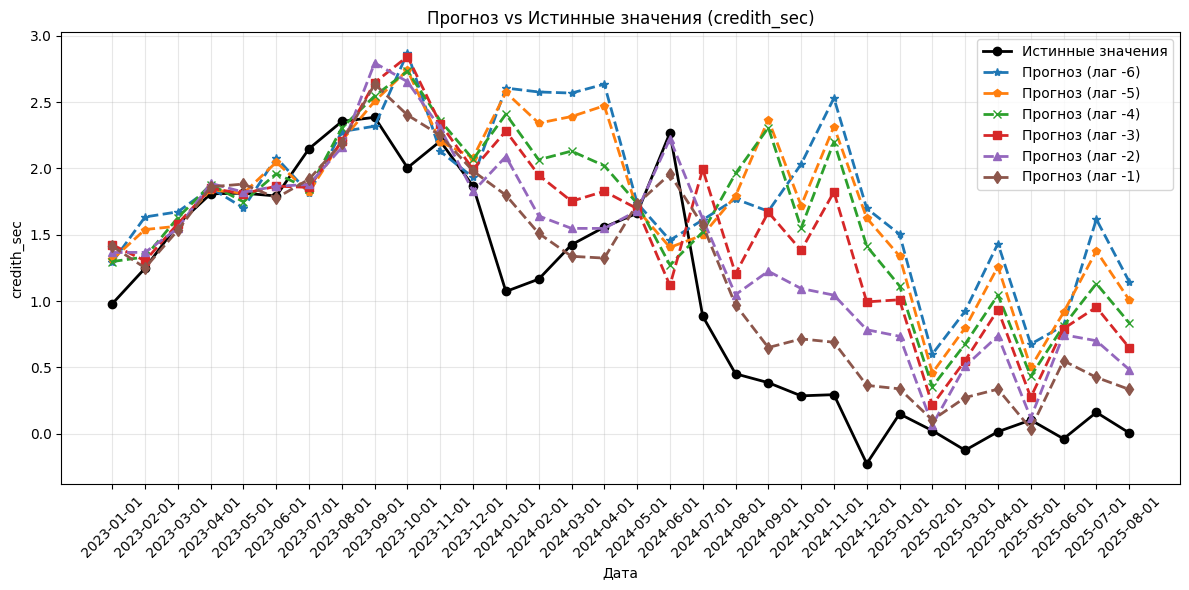

None


In [ ]:
print(plot_lstm(actuals2, pred2, dates2))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


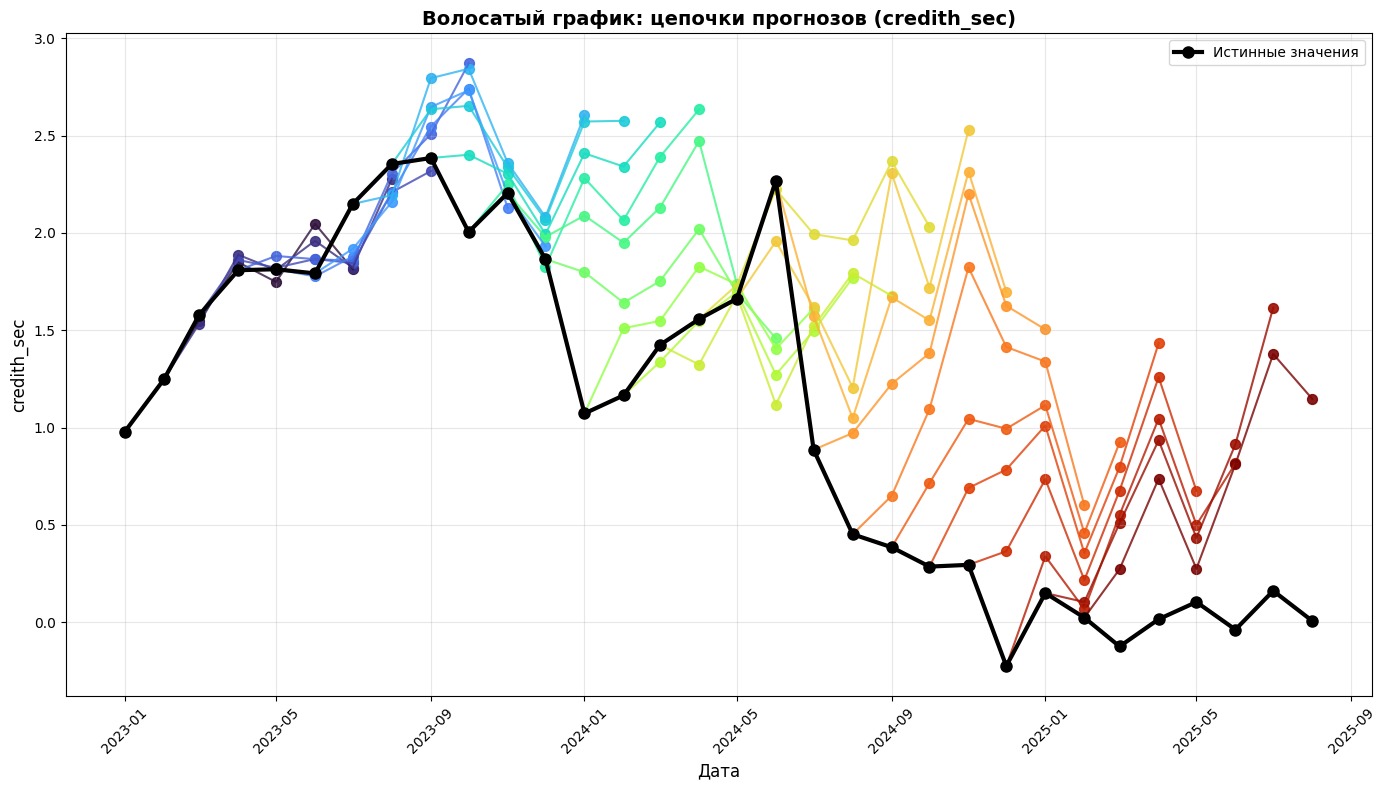

None


In [ ]:
print(plot_hair(actuals2, pred2, dates2))

# LSTM основа

In [ ]:
train = data_cr.loc[(data_cr.date >= train_start_date) & (data_cr.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_cr.loc[(data_cr.date >= train_start_date) & (data_cr.date <= test_end_date), :].reset_index(drop=True)

In [ ]:
hyperparamets3 = hyperparameter_tuning(train, target_variable, n_timesteps_grid=[12], n_hidden_grid=[10,20])

NameError: name 'hyperparameter_tuning' is not defined

In [ ]:
#print(hyperparamets3["hyper_params"][0])

#hyperparamets3 = hyperparamets3["hyper_params"][0]

hyperparamets3 = {'n_models': 1, 'n_timesteps': 12, 'fill_na_func': np.nanmean, 'train_episodes': 200, 'batch_size': 30, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}

#hyper_params1 = [['n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a43f69179f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a43f69179f0>, 'train_episodes': 200, 'batch_size': 100, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 1, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}]]

In [ ]:
columns = data_cr.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals3, pred3, dates3 = evaluate_lstm(data_cr, test_start_date, test_end_date, hyperparamets3, target_variable,  credith_mean, credith_std)

/tmp/ipython-input-1388537349.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  0.7455  0.8643
1    5  0.6500  0.7536
2    4  0.5671  0.6575
3    3  0.4840  0.5612
4    2  0.3982  0.4616
5    1  0.3168  0.3672


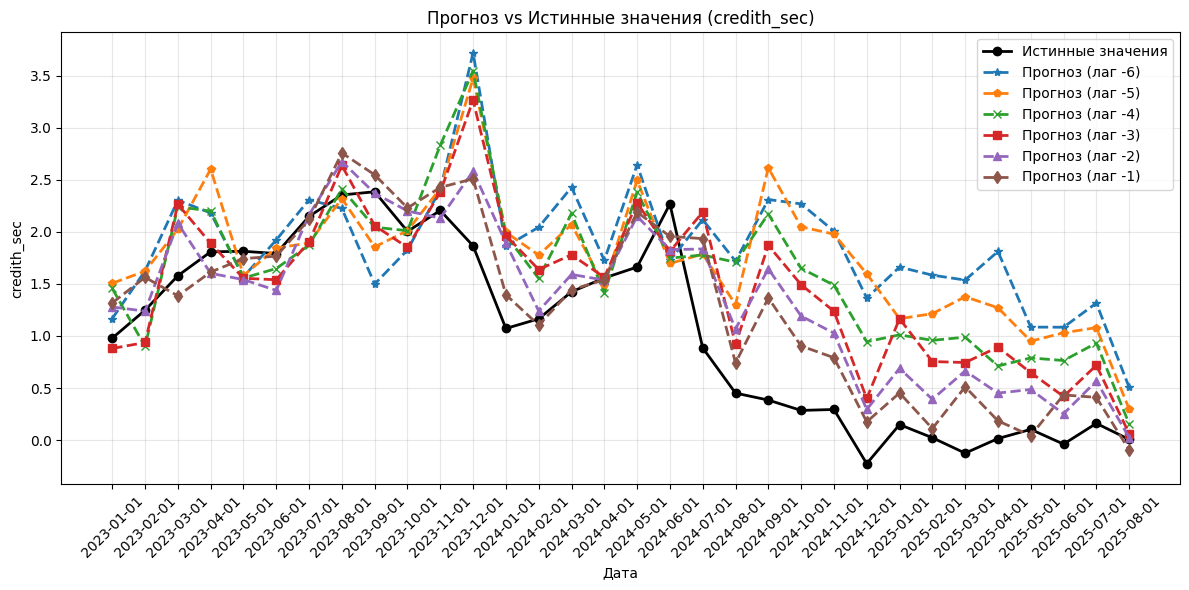

None


In [ ]:
print(plot_lstm(actuals3, pred3, dates3))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


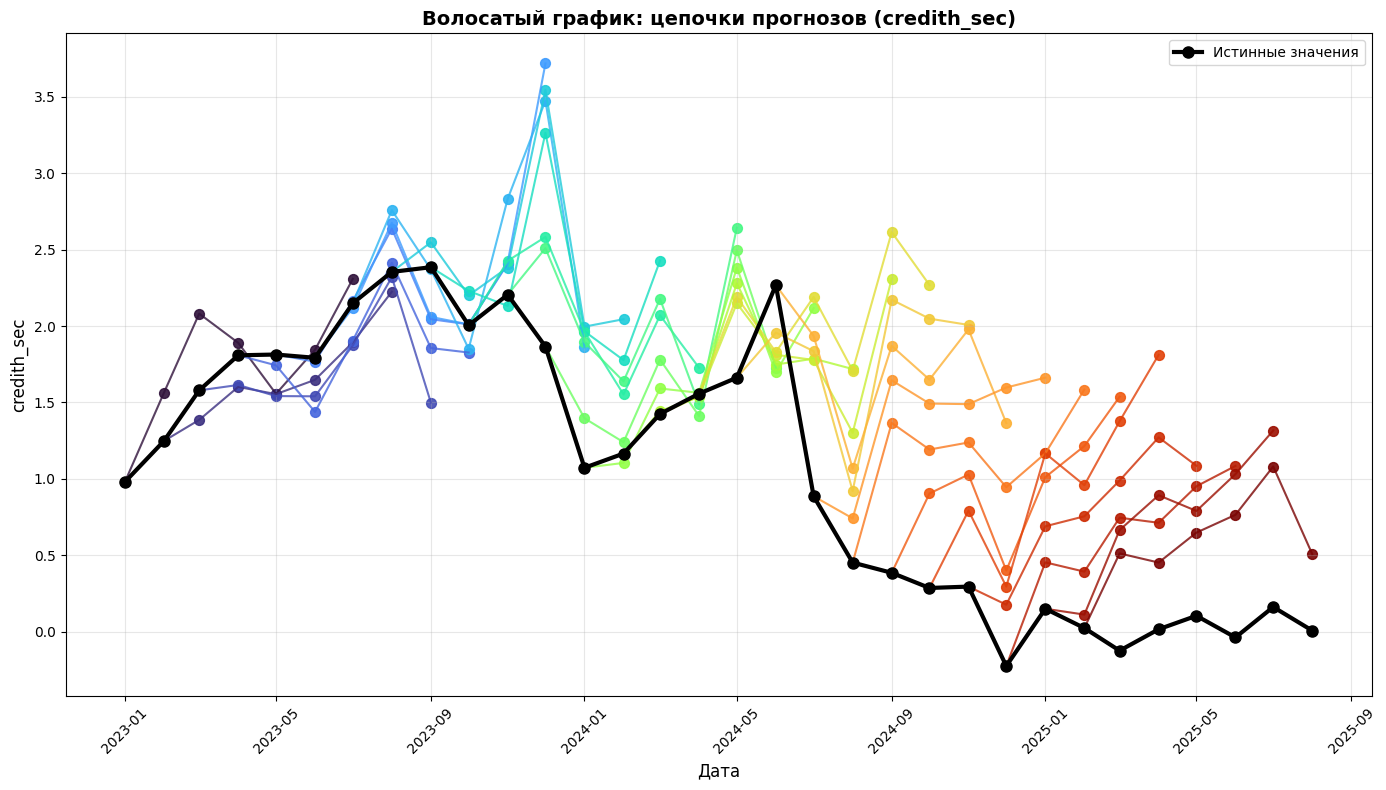

None


In [ ]:
print(plot_hair(actuals3, pred3, dates3))

## **ПЕРЕМЕННАЯ MORTGAGE_RUB**

In [ ]:
target_variable = "mortgage_rub"
data_mor = data[["date", target_variable, "ort", "ort_food", "ort_nonfood", "opu", "cater", "nzp", "rzp", "oot", "stro", "houses", "u_lvl", "unemployed", "l_dem", "consump", "pmi_mnf", "pmi_serv", "pmi_comp", "cpi", "cpi_prod", "cpi_neprod", "cpi_serv", "core_cpi", "gdp", "potreb", "potrebh", "potrebgos", "vnok", "export", "import", "credh_sr", "credh_lr", "miacr", "ofz1", "ofz2", "ofz3", "ofz5", "ofz10", "mrtg", "ubk_h", "nubk_h", "usdrub", "urals", "housetwomosc", "housetworus", "houseonemosc", "houseonerus", "d_mortgage"]]

columns = data_mor.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in data_mor.columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date
lags = list(range(-6, 0)) #прогнозируем от одного до 6 месяцев
print(lags)
# train and test dates
train_start_date = "2009-04-01"
train_end_date = "2023-12-01"
test_start_date = "2024-01-01"
test_end_date = "2025-08-01"

[-6, -5, -4, -3, -2, -1]


# Смешанный способ настройки гиперпараметров

In [ ]:
train = data_mor.loc[(data_mor.date >= train_start_date) & (data_mor.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_mor.loc[(data_mor.date >= train_start_date) & (data_mor.date <= test_end_date), :].reset_index(drop=True)

selection_results = select_model(train, target_variable, n_timesteps_grid = [12], n_hidden_grid = [10, 20], performance_metric="RMSE", lags = [-3, -2, -1])

tuning: 0 / 2
multivariate stage: 0 / 47 columns
multivariate stage: 1 / 47 columns
multivariate stage: 2 / 47 columns
multivariate stage: 3 / 47 columns
multivariate stage: 4 / 47 columns
multivariate stage: 5 / 47 columns
multivariate stage: 6 / 47 columns
multivariate stage: 7 / 47 columns
multivariate stage: 8 / 47 columns
multivariate stage: 9 / 47 columns
multivariate stage: 10 / 47 columns
multivariate stage: 11 / 47 columns
multivariate stage: 12 / 47 columns
multivariate stage: 13 / 47 columns
multivariate stage: 14 / 47 columns
multivariate stage: 15 / 47 columns
multivariate stage: 16 / 47 columns
multivariate stage: 17 / 47 columns
multivariate stage: 18 / 47 columns
multivariate stage: 19 / 47 columns
multivariate stage: 20 / 47 columns
multivariate stage: 21 / 47 columns
multivariate stage: 22 / 47 columns
multivariate stage: 23 / 47 columns
multivariate stage: 24 / 47 columns
multivariate stage: 25 / 47 columns
multivariate stage: 26 / 47 columns
multivariate stage: 27 /

In [ ]:
#отобранные переменные
selection_results.iloc[0,0]

['l_dem',
 'urals',
 'ubk_h',
 'potrebgos',
 'mrtg',
 'pmi_mnf',
 'cater',
 'potreb',
 'usdrub']

In [ ]:
#настройки сети
#mortgage1 = selection_results.iloc[0,1]
#print(mortgage1)

mortgage1 = {'n_models': 1, 'n_timesteps': 12, 'fill_na_func': np.nanmean, 'fill_ragged_edges_func': np.nanmean, 'train_episodes': 200, 'batch_size': 50, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}

#{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a43f69179f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a43f69179f0>, 'train_episodes': 200, 'batch_size': 50, 'decay': 0.98, 'n_hidden': 10, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}

In [ ]:
data_cut = data_mor[["date", target_variable, 'l_dem',
 'urals',
 'ubk_h',
 'potrebgos',
 'mrtg',
 'pmi_mnf',
 'cater',
 'potreb',
 'usdrub']]

columns = data_cut.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
train = data_cut.loc[(data_cut.date >= train_start_date) & (data_cut.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_cut.loc[(data_cut.date >= train_start_date) & (data_cut.date <= test_end_date), :].reset_index(drop=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals4, pred4, dates4 = evaluate_lstm(data_cut, test_start_date, test_end_date, mortgage1, target_variable,  mortgage_mean, mortgage_std)

/tmp/ipython-input-1388537349.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  1.1767  1.5318
1    5  0.9274  1.2072
2    4  0.7978  1.0385
3    3  0.7148  0.9305
4    2  0.5661  0.7370
5    1  0.4777  0.6218


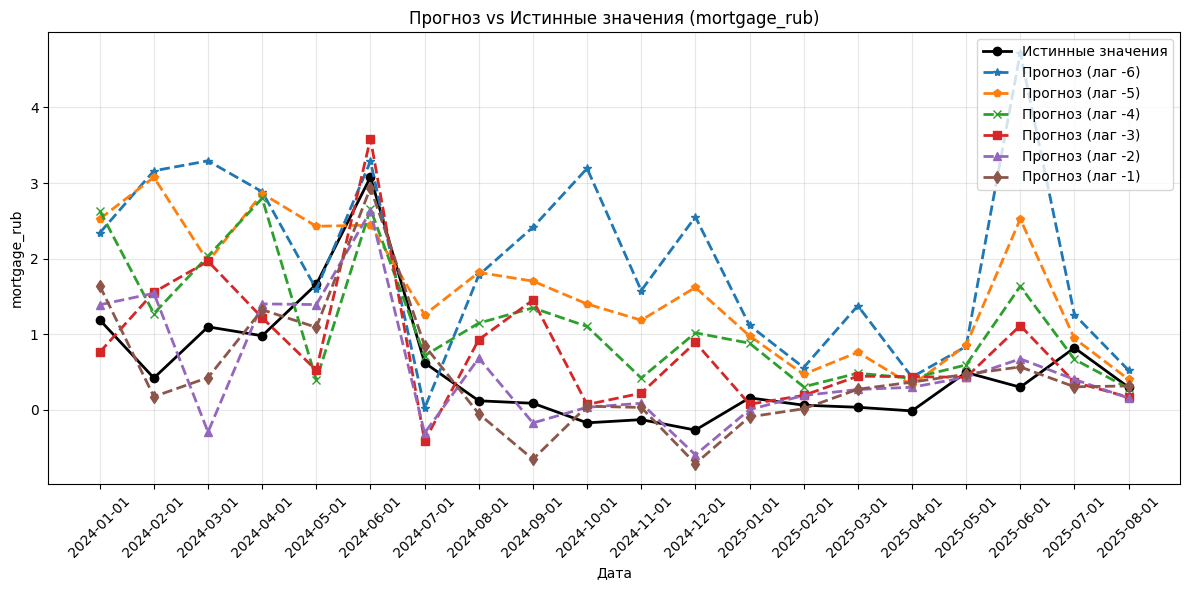

None


In [ ]:
print(plot_lstm(actuals4, pred4, dates4))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


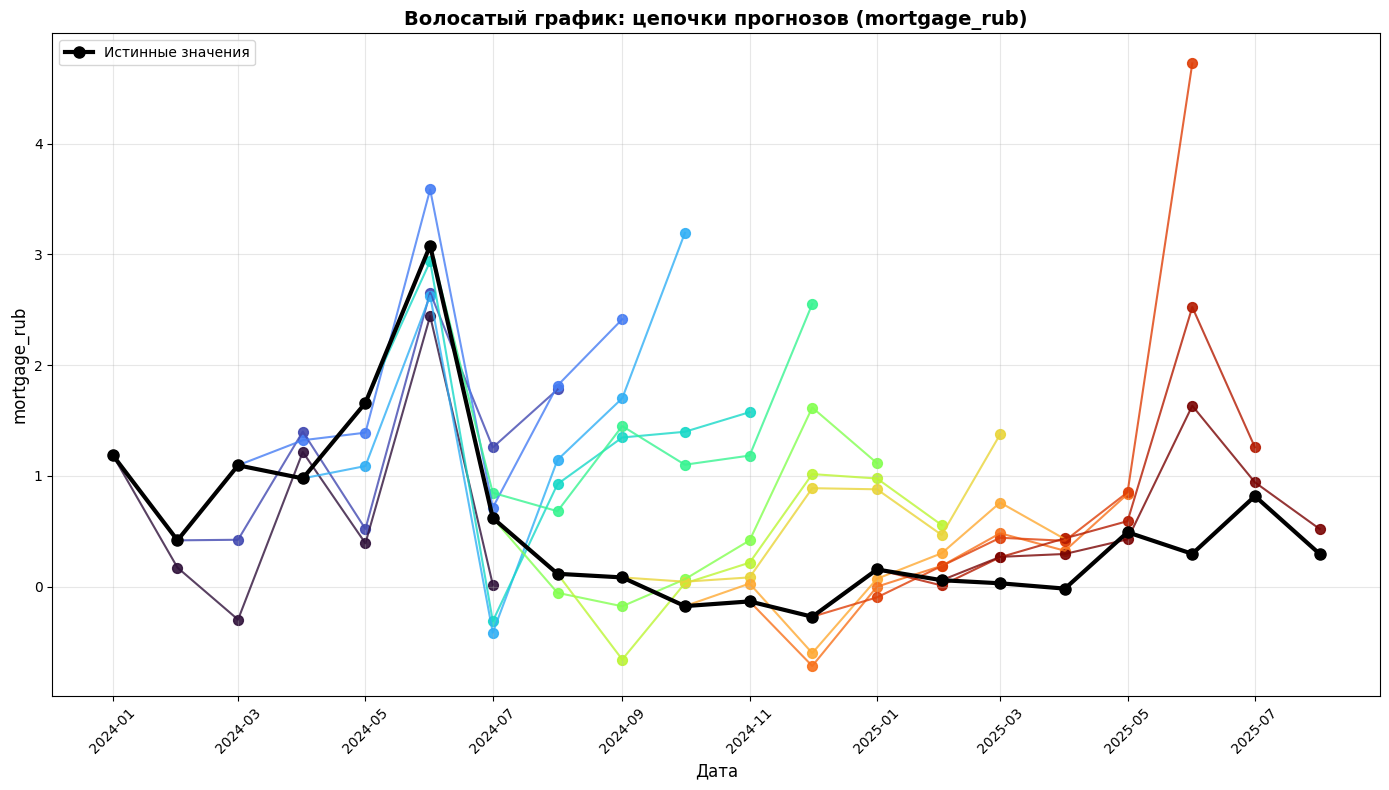

None


In [ ]:
print(plot_hair(actuals4, pred4, dates4))

# С частью переменных

In [ ]:
data_cut2 = data_mor[["date", target_variable, 'consump',
 'u_lvl',
 'gdp',
 'potrebh',
 'miacr',
 'ofz5',
 'credh_sr',
 'credh_lr',
 'usdrub',
 'urals',
 'rzp']]

columns = data_cut2.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
train = data_cut2.loc[(data_cut2.date >= train_start_date) & (data_cut2.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_cut2.loc[(data_cut2.date >= train_start_date) & (data_cut2.date <= test_end_date), :].reset_index(drop=True)

In [ ]:
mortgage2 = hyperparameter_tuning(train, target_variable, n_timesteps_grid=[12], n_hidden_grid=[10,20], performance_metric='RMSE')
#mortgage22 = hyperparameter_tuning(data, target_variable, n_models=10, n_timesteps_grid = [6, 12], train_episodes_grid = [100, 200], batch_size_grid = [30], n_hidden_grid = [10, 20], n_layers_grid = [2], n_folds=2)

tuning: 0 / 54
tuning: 1 / 54
tuning: 2 / 54
tuning: 3 / 54
tuning: 4 / 54
tuning: 5 / 54
tuning: 6 / 54
tuning: 7 / 54
tuning: 8 / 54
tuning: 9 / 54
tuning: 10 / 54
tuning: 11 / 54
tuning: 12 / 54
tuning: 13 / 54
tuning: 14 / 54
tuning: 15 / 54
tuning: 16 / 54
tuning: 17 / 54
tuning: 18 / 54
tuning: 19 / 54
tuning: 20 / 54
tuning: 21 / 54
tuning: 22 / 54
tuning: 23 / 54
tuning: 24 / 54
tuning: 25 / 54
tuning: 26 / 54
tuning: 27 / 54
tuning: 28 / 54
tuning: 29 / 54
tuning: 30 / 54
tuning: 31 / 54
tuning: 32 / 54
tuning: 33 / 54
tuning: 34 / 54
tuning: 35 / 54
tuning: 36 / 54
tuning: 37 / 54
tuning: 38 / 54
tuning: 39 / 54
tuning: 40 / 54
tuning: 41 / 54
tuning: 42 / 54
tuning: 43 / 54
tuning: 44 / 54
tuning: 45 / 54
tuning: 46 / 54
tuning: 47 / 54
tuning: 48 / 54
tuning: 49 / 54
tuning: 50 / 54
tuning: 51 / 54
tuning: 52 / 54
tuning: 53 / 54


In [ ]:
print(mortgage2["hyper_params"][0])

mortgage2 = mortgage2["hyper_params"][0]

{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a0d00b3bd30>, 'fill_ragged_edges_func': <function nanmean at 0x7a0d00b3bd30>, 'train_episodes': 100, 'batch_size': 30, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals5, pred5, dates5 = evaluate_lstm(data_cut2, test_start_date, test_end_date, mortgage2, target_variable,  mortgage_mean, mortgage_std)

/tmp/ipython-input-1388537349.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  1.1637  1.5148
1    5  1.0814  1.4077
2    4  1.0145  1.3207
3    3  0.9212  1.1991
4    2  0.8125  1.0576
5    1  0.6765  0.8806


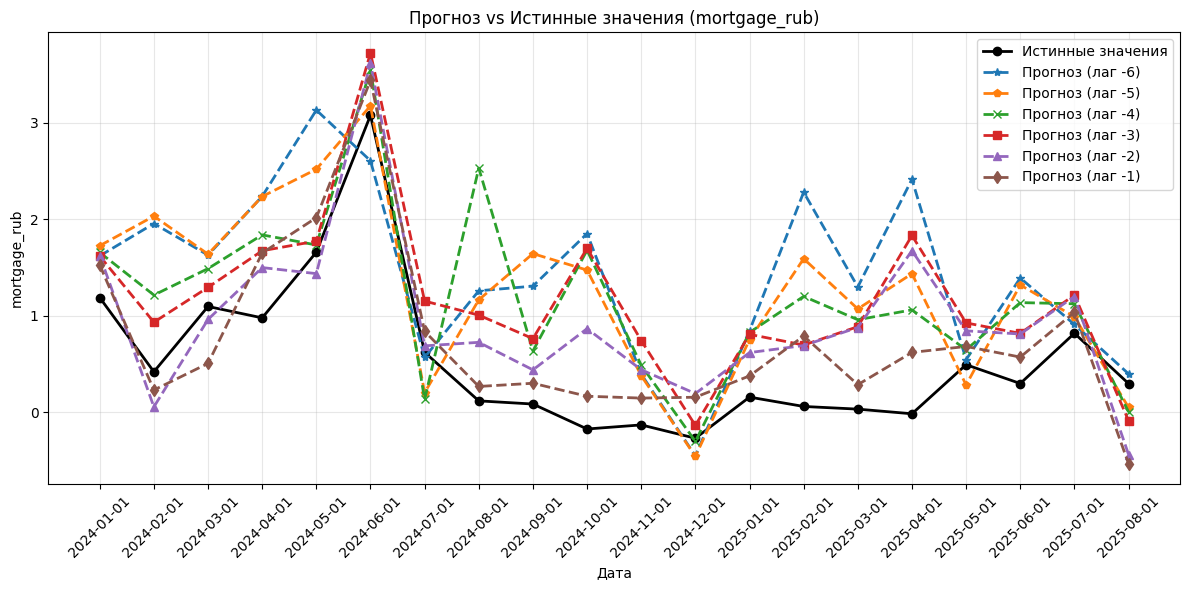

None


In [ ]:
print(plot_lstm(actuals5, pred5, dates5))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


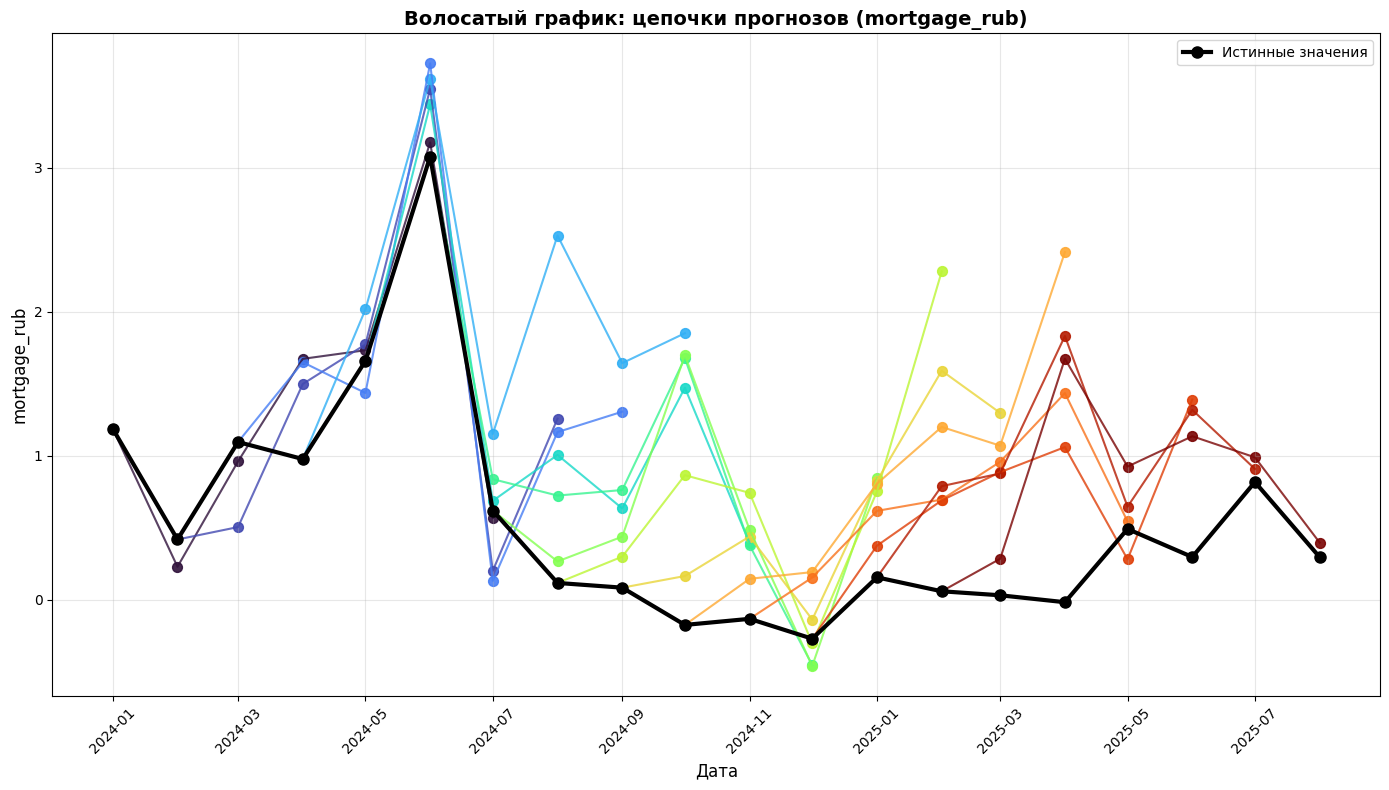

None


In [ ]:
print(plot_hair(actuals5, pred5, dates5))

# LSTM ОСНОВА

In [ ]:
train = data_mor.loc[(data_mor.date >= train_start_date) & (data_mor.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_mor.loc[(data_mor.date >= train_start_date) & (data_mor.date <= test_end_date), :].reset_index(drop=True)

In [ ]:
mortgage3 = hyperparameter_tuning(train, target_variable, n_timesteps_grid=[12], n_hidden_grid=[10,20])

tuning: 0 / 54
tuning: 1 / 54
tuning: 2 / 54
tuning: 3 / 54
tuning: 4 / 54
tuning: 5 / 54
tuning: 6 / 54
tuning: 7 / 54
tuning: 8 / 54
tuning: 9 / 54
tuning: 10 / 54
tuning: 11 / 54
tuning: 12 / 54
tuning: 13 / 54
tuning: 14 / 54
tuning: 15 / 54
tuning: 16 / 54
tuning: 17 / 54
tuning: 18 / 54
tuning: 19 / 54
tuning: 20 / 54
tuning: 21 / 54
tuning: 22 / 54
tuning: 23 / 54
tuning: 24 / 54
tuning: 25 / 54
tuning: 26 / 54
tuning: 27 / 54
tuning: 28 / 54
tuning: 29 / 54
tuning: 30 / 54
tuning: 31 / 54
tuning: 32 / 54
tuning: 33 / 54
tuning: 34 / 54
tuning: 35 / 54
tuning: 36 / 54
tuning: 37 / 54
tuning: 38 / 54
tuning: 39 / 54
tuning: 40 / 54
tuning: 41 / 54
tuning: 42 / 54
tuning: 43 / 54
tuning: 44 / 54
tuning: 45 / 54
tuning: 46 / 54
tuning: 47 / 54
tuning: 48 / 54
tuning: 49 / 54
tuning: 50 / 54
tuning: 51 / 54
tuning: 52 / 54
tuning: 53 / 54


In [ ]:
print(mortgage3["hyper_params"][0])

mortgage3 = mortgage3["hyper_params"][0]

# {'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a20d69696f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a20d69696f0>, 'train_episodes': 50, 'batch_size': 100, 'decay': 0.98, 'n_hidden': 10, 'n_layers': 1, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}

{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a20d69696f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a20d69696f0>, 'train_episodes': 50, 'batch_size': 100, 'decay': 0.98, 'n_hidden': 10, 'n_layers': 1, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}


In [ ]:
columns = data_mor.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals6, pred6, dates6 = evaluate_lstm(data_mor, test_start_date, test_end_date, mortgage3, target_variable,  mortgage_mean, mortgage_std)

/tmp/ipython-input-2215130985.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  0.9945  1.2946
1    5  0.9120  1.1871
2    4  0.8146  1.0604
3    3  0.7038  0.9161
4    2  0.5952  0.7747
5    1  0.4942  0.6434


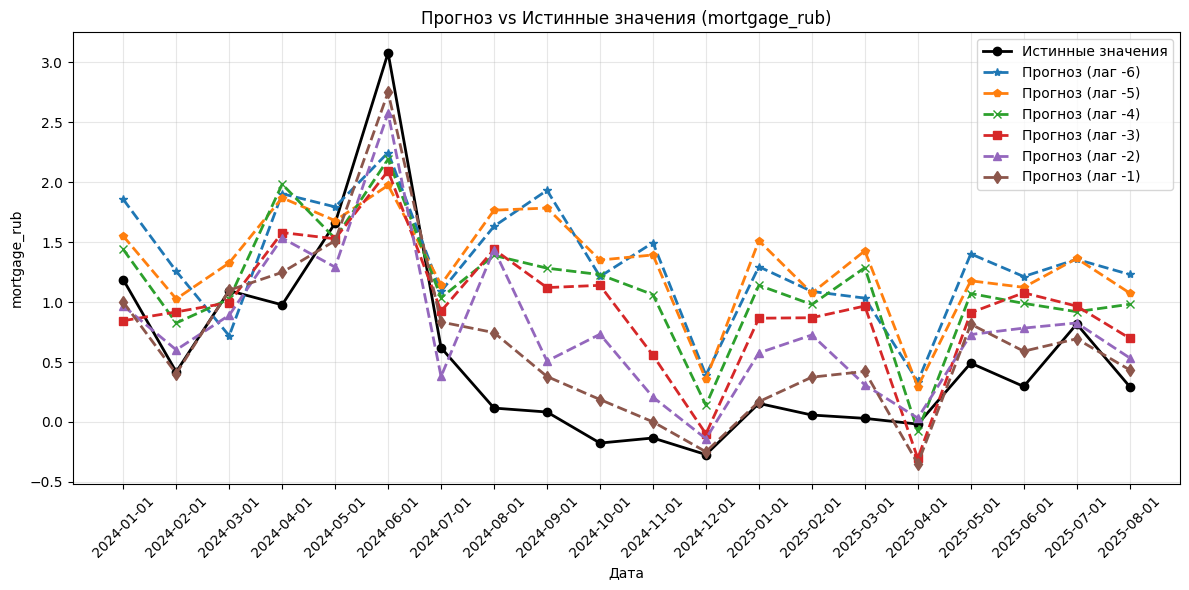

None


In [ ]:
print(plot_lstm(actuals6, pred6, dates6))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


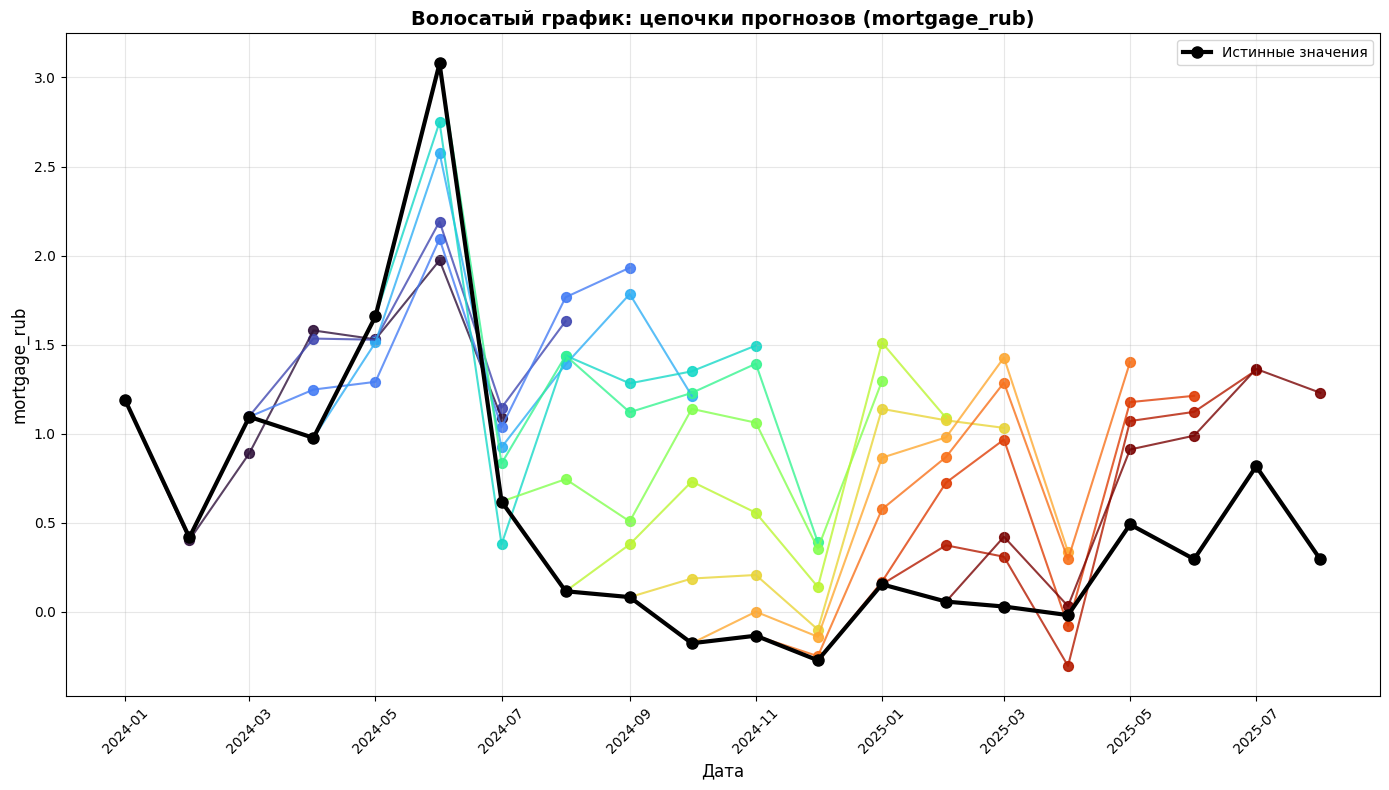

None


In [ ]:
print(plot_hair(actuals6, pred6, dates6))

# **ПЕРЕМЕННАЯ POTREB_RUB**

In [ ]:
target_variable = "potreb_rub"
data_po = data[["date", target_variable, "ort", "ort_food", "ort_nonfood", "opu", "cater", "nzp", "rzp", "oot", "stro", "houses", "u_lvl", "unemployed", "l_dem", "consump", "pmi_mnf", "pmi_serv", "pmi_comp", "cpi", "cpi_prod", "cpi_neprod", "cpi_serv", "core_cpi", "gdp", "potreb", "potrebh", "potrebgos", "vnok", "export", "import", "credh_sr", "credh_lr", "miacr", "ofz1", "ofz2", "ofz3", "ofz5", "ofz10", "mrtg", "ubk_h", "nubk_h", "usdrub", "urals", "housetwomosc", "housetworus", "houseonemosc", "houseonerus", "d_mortgage"]]

columns = data_po.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in data_po.columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
# train and test dates
train_start_date = "2009-05-01"
train_end_date = "2023-12-01"
test_start_date = "2024-01-01"
test_end_date = "2025-08-01"

train = data_po.loc[(data_po.date >= train_start_date) & (data_po.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_po.loc[(data_po.date >= train_start_date) & (data_po.date <= test_end_date), :].reset_index(drop=True)

# СМЕШАННЫЙ ПОДБОР ГИПЕРПАРАМЕТРОВ

In [ ]:
selection_results = select_model(train, target_variable, n_timesteps_grid = [12], n_hidden_grid = [10, 20], performance_metric="RMSE", lags = [-3, -2, -1])

tuning: 0 / 2
multivariate stage: 0 / 47 columns
multivariate stage: 1 / 47 columns
multivariate stage: 2 / 47 columns
multivariate stage: 3 / 47 columns
multivariate stage: 4 / 47 columns
multivariate stage: 5 / 47 columns
multivariate stage: 6 / 47 columns
multivariate stage: 7 / 47 columns
multivariate stage: 8 / 47 columns
multivariate stage: 9 / 47 columns
multivariate stage: 10 / 47 columns
multivariate stage: 11 / 47 columns
multivariate stage: 12 / 47 columns
multivariate stage: 13 / 47 columns
multivariate stage: 14 / 47 columns
multivariate stage: 15 / 47 columns
multivariate stage: 16 / 47 columns
multivariate stage: 17 / 47 columns
multivariate stage: 18 / 47 columns
multivariate stage: 19 / 47 columns
multivariate stage: 20 / 47 columns
multivariate stage: 21 / 47 columns
multivariate stage: 22 / 47 columns
multivariate stage: 23 / 47 columns
multivariate stage: 24 / 47 columns
multivariate stage: 25 / 47 columns
multivariate stage: 26 / 47 columns
multivariate stage: 27 /

In [ ]:
#отобранные переменные
selection_results.iloc[0,0]

['urals',
 'miacr',
 'core_cpi',
 'pmi_mnf',
 'ofz1',
 'rzp',
 'ort_nonfood',
 'ort_food']

In [ ]:
#настройки сети
potreb1 = selection_results.iloc[0,1]
print(potreb1)
#{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a43f69179f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a43f69179f0>, 'train_episodes': 200, 'batch_size': 50, 'decay': 0.98, 'n_hidden': 10, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}

{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a20d69696f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a20d69696f0>, 'train_episodes': 200, 'batch_size': 50, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}


In [ ]:
data_cut = data_po[["date", target_variable, 'urals',
 'miacr',
 'core_cpi',
 'pmi_mnf',
 'ofz1',
 'rzp',
 'ort_nonfood',
 'ort_food']]

columns = data_cut.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
train = data_cut.loc[(data_cut.date >= train_start_date) & (data_cut.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_cut.loc[(data_cut.date >= train_start_date) & (data_cut.date <= test_end_date), :].reset_index(drop=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals7, pred7, dates7 = evaluate_lstm(data_cut, test_start_date, test_end_date, potreb1, target_variable,  potreb_mean, potreb_std)

/tmp/ipython-input-2215130985.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  1.2799  1.0377
1    5  1.1797  0.9564
2    4  1.0578  0.8576
3    3  0.9378  0.7603
4    2  0.8386  0.6799
5    1  0.6758  0.5479


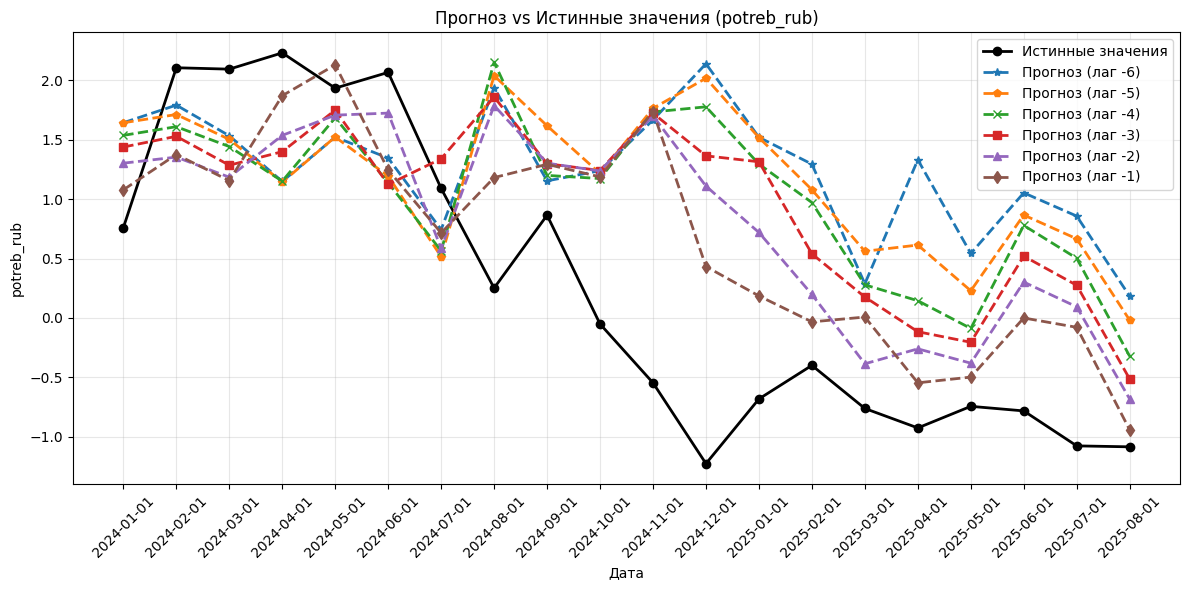

None


In [ ]:
print(plot_lstm(actuals7, pred7, dates7))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


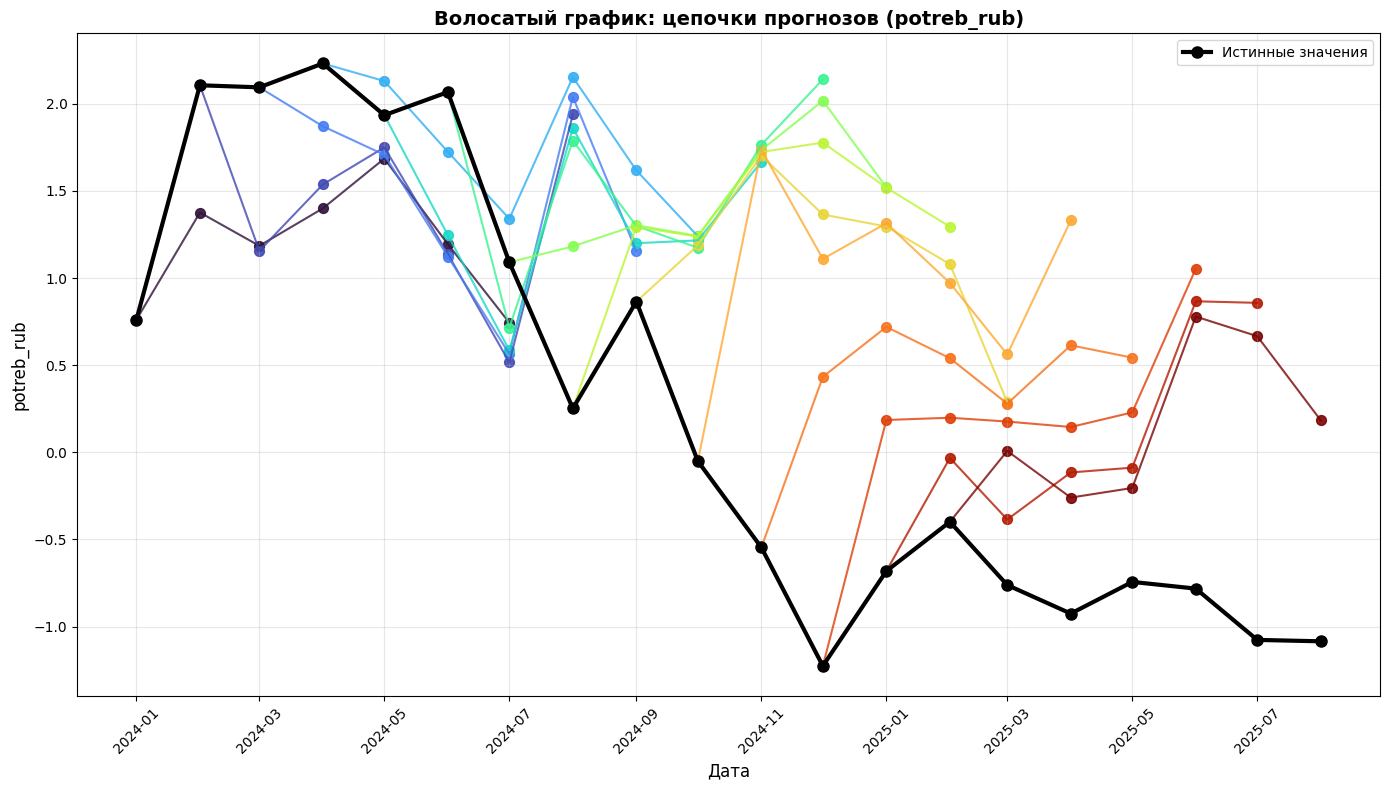

None


In [ ]:
print(plot_hair(actuals7, pred7, dates7))

# С частью переменных

In [ ]:
data_cut2 = data_po[["date", target_variable, 'consump',
 'u_lvl',
 'gdp',
 'potrebh',
 'miacr',
 'ofz5',
 'credh_sr',
 'credh_lr',
 'usdrub',
 'urals',
 'rzp']]

columns = data_cut2.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
train = data_cut2.loc[(data_cut2.date >= train_start_date) & (data_cut2.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_cut2.loc[(data_cut2.date >= train_start_date) & (data_cut2.date <= test_end_date), :].reset_index(drop=True)

In [ ]:
potreb2 = hyperparameter_tuning(train, target_variable, n_timesteps_grid=[12], n_hidden_grid=[10,20])

tuning: 0 / 54
tuning: 1 / 54
tuning: 2 / 54
tuning: 3 / 54
tuning: 4 / 54
tuning: 5 / 54
tuning: 6 / 54
tuning: 7 / 54
tuning: 8 / 54
tuning: 9 / 54
tuning: 10 / 54
tuning: 11 / 54
tuning: 12 / 54
tuning: 13 / 54
tuning: 14 / 54
tuning: 15 / 54
tuning: 16 / 54
tuning: 17 / 54
tuning: 18 / 54
tuning: 19 / 54
tuning: 20 / 54
tuning: 21 / 54
tuning: 22 / 54
tuning: 23 / 54
tuning: 24 / 54
tuning: 25 / 54
tuning: 26 / 54
tuning: 27 / 54
tuning: 28 / 54
tuning: 29 / 54
tuning: 30 / 54
tuning: 31 / 54
tuning: 32 / 54
tuning: 33 / 54
tuning: 34 / 54
tuning: 35 / 54
tuning: 36 / 54
tuning: 37 / 54
tuning: 38 / 54
tuning: 39 / 54
tuning: 40 / 54
tuning: 41 / 54
tuning: 42 / 54
tuning: 43 / 54
tuning: 44 / 54
tuning: 45 / 54
tuning: 46 / 54
tuning: 47 / 54
tuning: 48 / 54
tuning: 49 / 54
tuning: 50 / 54
tuning: 51 / 54
tuning: 52 / 54
tuning: 53 / 54


In [ ]:
print(potreb2["hyper_params"][0])

potreb2 = potreb2["hyper_params"][0]

{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a20d69696f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a20d69696f0>, 'train_episodes': 50, 'batch_size': 200, 'decay': 0.98, 'n_hidden': 10, 'n_layers': 1, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals8, pred8, dates8 = evaluate_lstm(data_cut2, test_start_date, test_end_date, potreb2, target_variable,  potreb_mean, potreb_std)

/tmp/ipython-input-2215130985.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  0.9466  0.7674
1    5  0.8642  0.7006
2    4  0.7705  0.6247
3    3  0.6635  0.5379
4    2  0.5926  0.4804
5    1  0.5139  0.4166


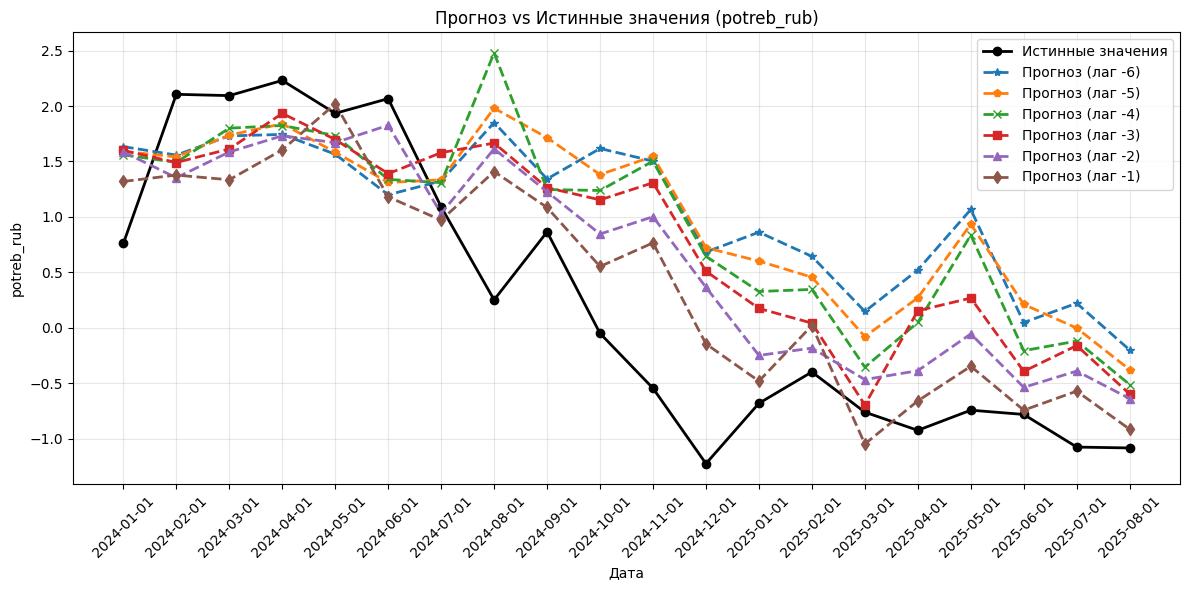

None


In [ ]:
print(plot_lstm(actuals8, pred8, dates8))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


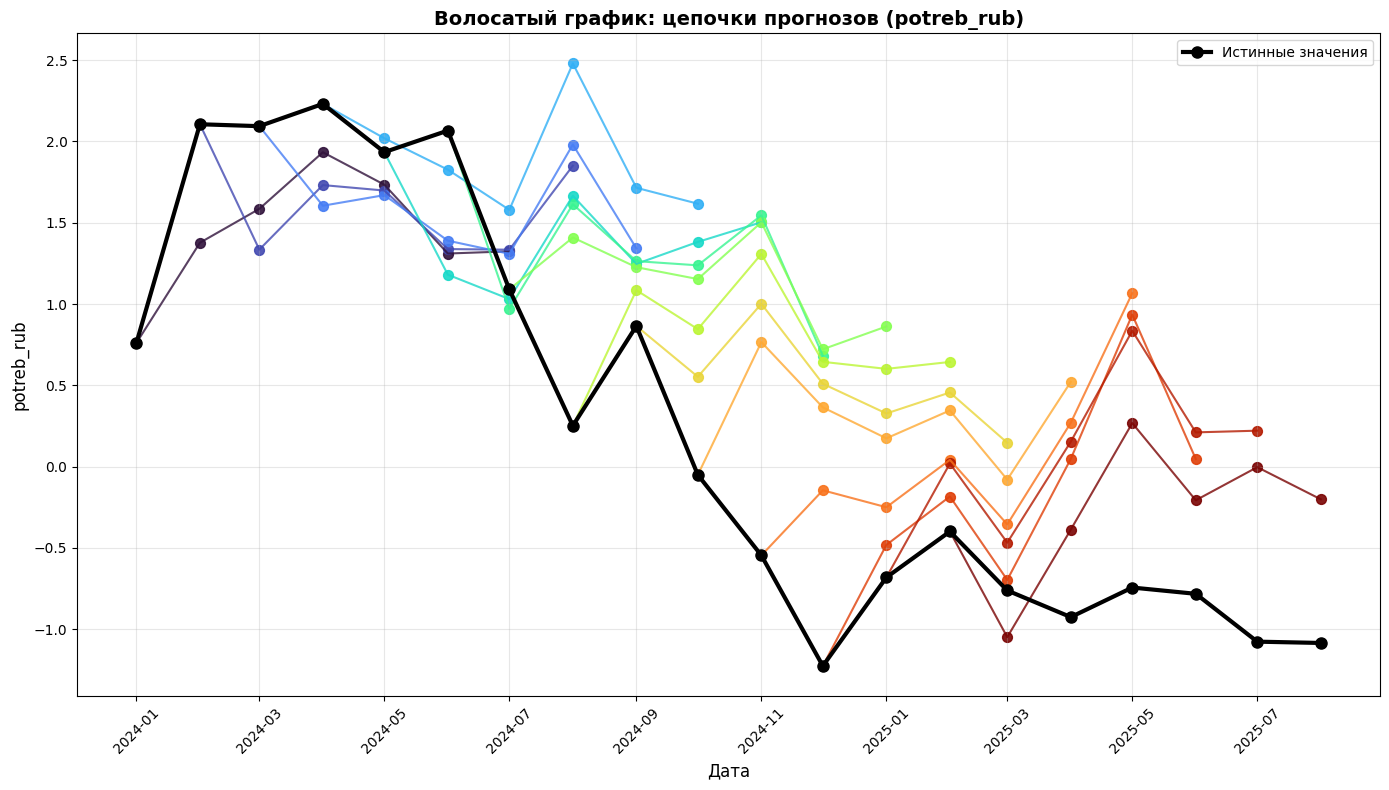

None


In [ ]:
print(plot_hair(actuals8, pred8, dates8))

# LSTM ОСНОВА

In [ ]:
train = data_po.loc[(data_po.date >= train_start_date) & (data_po.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_po.loc[(data_po.date >= train_start_date) & (data_po.date <= test_end_date), :].reset_index(drop=True)

In [ ]:
potreb3 = hyperparameter_tuning(train, target_variable, n_timesteps_grid=[12], n_hidden_grid=[10,20])

tuning: 0 / 54
tuning: 1 / 54
tuning: 2 / 54
tuning: 3 / 54
tuning: 4 / 54
tuning: 5 / 54
tuning: 6 / 54
tuning: 7 / 54
tuning: 8 / 54
tuning: 9 / 54
tuning: 10 / 54
tuning: 11 / 54
tuning: 12 / 54
tuning: 13 / 54
tuning: 14 / 54
tuning: 15 / 54
tuning: 16 / 54
tuning: 17 / 54
tuning: 18 / 54
tuning: 19 / 54
tuning: 20 / 54
tuning: 21 / 54
tuning: 22 / 54
tuning: 23 / 54
tuning: 24 / 54
tuning: 25 / 54
tuning: 26 / 54
tuning: 27 / 54
tuning: 28 / 54
tuning: 29 / 54
tuning: 30 / 54
tuning: 31 / 54
tuning: 32 / 54
tuning: 33 / 54
tuning: 34 / 54
tuning: 35 / 54
tuning: 36 / 54
tuning: 37 / 54
tuning: 38 / 54
tuning: 39 / 54
tuning: 40 / 54
tuning: 41 / 54
tuning: 42 / 54
tuning: 43 / 54
tuning: 44 / 54
tuning: 45 / 54
tuning: 46 / 54
tuning: 47 / 54
tuning: 48 / 54
tuning: 49 / 54
tuning: 50 / 54
tuning: 51 / 54
tuning: 52 / 54
tuning: 53 / 54


In [ ]:
print(potreb3["hyper_params"][0])

potreb3 = potreb3["hyper_params"][0]

{'n_models': 1, 'n_timesteps': 12, 'fill_na_func': <function nanmean at 0x7a20d69696f0>, 'fill_ragged_edges_func': <function nanmean at 0x7a20d69696f0>, 'train_episodes': 50, 'batch_size': 30, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}


In [ ]:
potreb3 = {'n_models': 1, 'n_timesteps': 12, 'fill_na_func': np.nanmean, 'fill_ragged_edges_func': np.nanmean, 'train_episodes': 200, 'batch_size': 30, 'decay': 0.98, 'n_hidden': 20, 'n_layers': 2, 'dropout': 0, 'criterion': '', 'optimizer': '', 'optimizer_parameters': {'lr': 0.01}}

In [ ]:
columns = data_po.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

actuals9, pred9, dates9 = evaluate_lstm(data_po, test_start_date, test_end_date, potreb3, target_variable,  potreb_mean, potreb_std)

/tmp/ipython-input-1388537349.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)


   Lag    RMSE   NRMSE
0    6  0.8642  0.7006
1    5  0.8277  0.6711
2    4  0.7721  0.6260
3    3  0.6989  0.5666
4    2  0.6225  0.5047
5    1  0.5215  0.4228


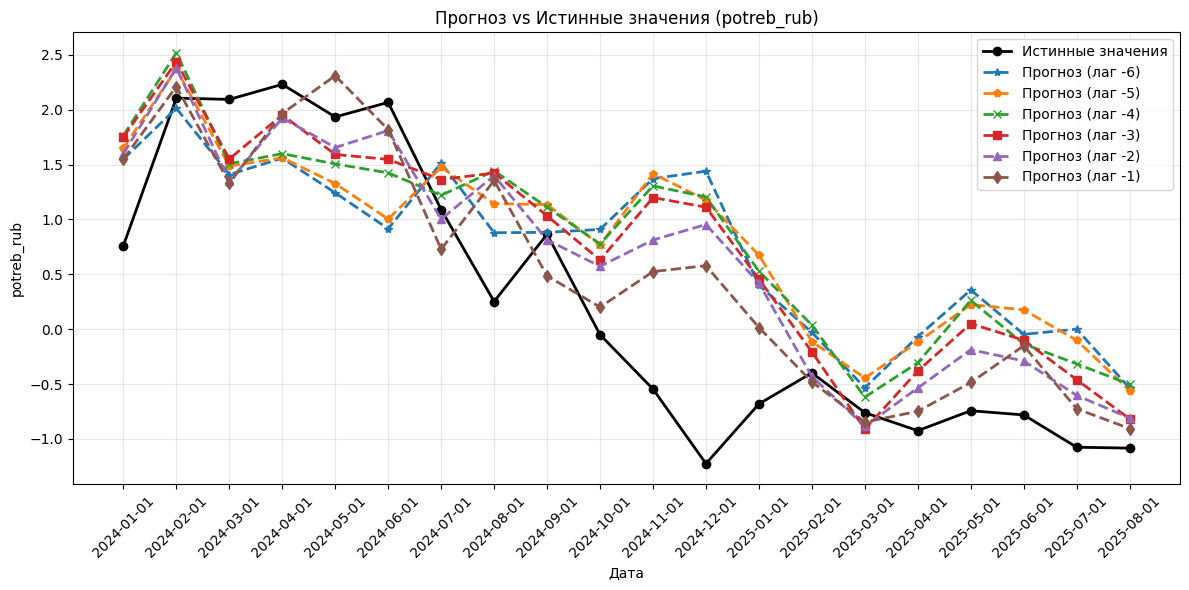

None


In [ ]:
print(plot_lstm(actuals9, pred9, dates9))

/tmp/ipython-input-1595821705.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")     # красивая яркая палитра


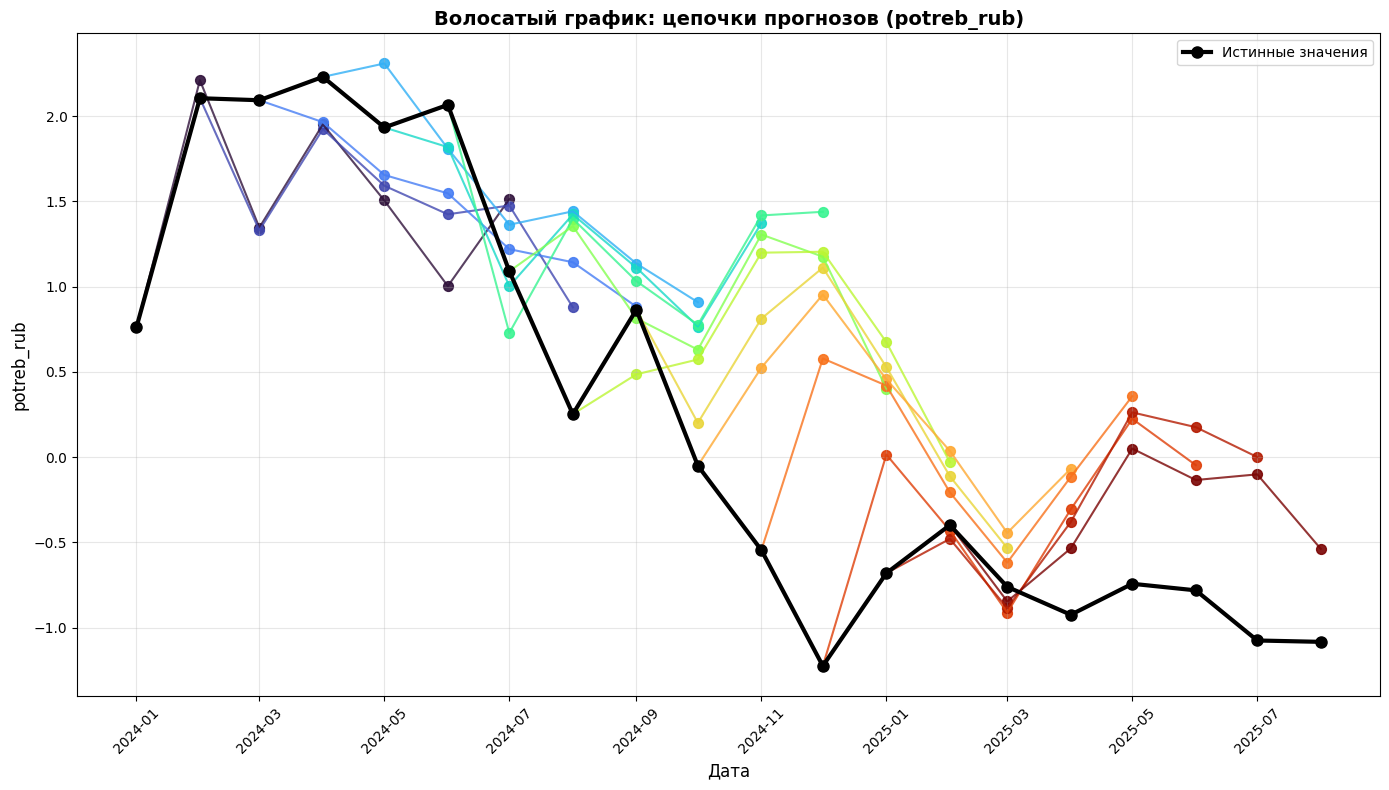

None


In [ ]:
print(plot_hair(actuals9, pred9, dates9))

# ЭКСПОРТ

In [ ]:
export_data = pd.DataFrame({
    'Dates': dates2,
    'Credith_real': actuals2,
    # 'Credith_1_1': pred1[-1],
    # 'Credith_1_2': pred1[-2],
    # 'Credith_1_3': pred1[-3],
    # 'Credith_1_4': pred1[-4],
    # 'Credith_1_5': pred1[-5],
    # 'Credith_1_6': pred1[-6],
    'Credith_2_1': pred2[-1],
    'Credith_2_2': pred2[-2],
    'Credith_2_3': pred2[-3],
    'Credith_2_4': pred2[-4],
    'Credith_2_5': pred2[-5],
    'Credith_2_6': pred2[-6],
    # 'Credith_3_1': pred3[-1],
    # 'Credith_3_2': pred3[-2],
    # 'Credith_3_3': pred3[-3],
    # 'Credith_3_4': pred3[-4],
    # 'Credith_3_5': pred3[-5],
    # 'Credith_3_6': pred3[-6],
})

# Сохраняем в Excel
export_data.to_excel('credith_forecast.xlsx', index=False)

In [ ]:
  export_data2 = pd.DataFrame({
    'Dates': dates4,
    'Mortgage_real': actuals4,
    'Mortgage_1_1': pred4[-1],
    'Mortgage_1_2': pred4[-2],
    'Mortgage_1_3': pred4[-3],
    'Mortgage_1_4': pred4[-4],
    'Mortgage_1_5': pred4[-5],
    'Mortgage_1_6': pred4[-6],
    # 'Mortgage_2_1': pred5[-1],
    # 'Mortgage_2_2': pred5[-2],
    # 'Mortgage_2_3': pred5[-3],
    # 'Mortgage_2_4': pred5[-4],
    # 'Mortgage_2_5': pred5[-5],
    # 'Mortgage_2_6': pred5[-6],
    # 'Mortgage_3_1': pred6[-1],
    # 'Mortgage_3_2': pred6[-2],
    # 'Mortgage_3_3': pred6[-3],
    # 'Mortgage_3_4': pred6[-4],
    # 'Mortgage_3_5': pred6[-5],
    # 'Mortgage_3_6': pred6[-6],
    # 'Potreb_real': actuals7,
    # 'Potreb_1_1': pred7[-1],
    # 'Potreb_1_2': pred7[-2],
    # 'Potreb_1_3': pred7[-3],
    # 'Potreb_1_4': pred7[-4],
    # 'Potreb_1_5': pred7[-5],
    # 'Potreb_1_6': pred7[-6],
    # 'Potreb_2_1': pred8[-1],
    # 'Potreb_2_2': pred8[-2],
    # 'Potreb_2_3': pred8[-3],
    # 'Potreb_2_4': pred8[-4],
    # 'Potreb_2_5': pred8[-5],
    # 'Potreb_2_6': pred8[-6],
    'Potreb_3_1': pred9[-1],
    'Potreb_3_2': pred9[-2],
    'Potreb_3_3': pred9[-3],
    'Potreb_3_4': pred9[-4],
    'Potreb_3_5': pred9[-5],
    'Potreb_3_6': pred9[-6]
    })

  # Сохраняем в Excel
export_data2.to_excel('mo_po_forecast.xlsx', index=False)

In [ ]:
import os
print("Текущая директория:", os.getcwd())

Текущая директория: /content


# **НАУКАСТИНГ**

In [ ]:
target_variable = "credith_sec"
data_cut1 = data[["date", target_variable, 'consump',
 'u_lvl',
 'gdp',
 'potrebh',
 'miacr',
 'ofz5',
 'credh_sr',
 'credh_lr',
 'usdrub',
 'urals',
 'rzp']]

columns = data_cut1.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in data_cut1.columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date
lags = list(range(0, 1)) #прогнозируем от одного до трех месяцев
# train and test dates
train_start_date = "2002-03-01"
train_end_date = "2022-12-01"
test_start_date = "2023-01-01"
test_end_date = "2025-09-01"

# train and test datasets
test = data_cut1.loc[(data_cut1.date >= train_start_date) & (data_cut1.date <= test_end_date), :].reset_index(drop=True)

/tmp/ipython-input-2314231342.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)
/tmp/ipython-input-2314231342.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, tmp]).reset_index(drop=True)


  Vintage    RMSE     MAE
0       0  0.2648  0.2075


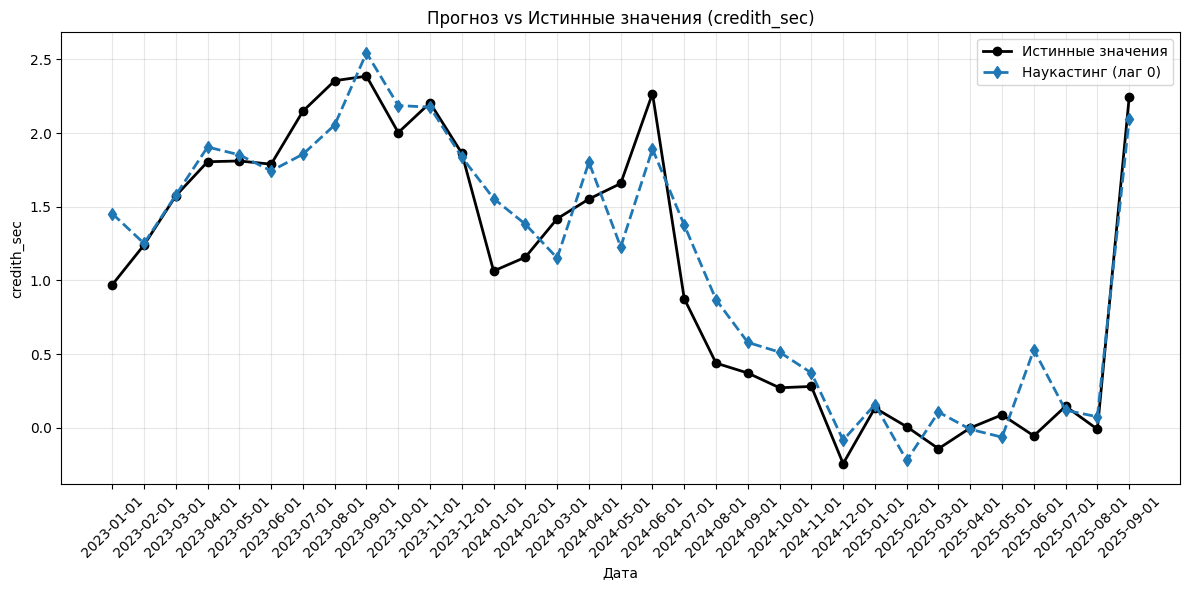

None


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

print(nowcasting_lstm(data_cut1, test_start_date, test_end_date, hyperparamets2, target_variable, credith_mean, credith_std, plot=1))

In [ ]:
target_variable = "mortgage_rub"
data_cut2 = data[["date", target_variable, 'consump',
 'u_lvl',
 'gdp',
 'potrebh',
 'miacr',
 'ofz5',
 'credh_sr',
 'credh_lr',
 'usdrub',
 'urals',
 'rzp']]

columns = data_cut2.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in data_cut2.columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date
lags = list(range(0, 1))

# train and test dates
train_start_date = "2009-04-01"
train_end_date = "2023-12-01"
test_start_date = "2024-01-01"
test_end_date = "2025-09-01"

/tmp/ipython-input-2314231342.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)
/tmp/ipython-input-2314231342.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, tmp]).reset_index(drop=True)


  Vintage    RMSE     MAE
0       0  0.4867  0.3728


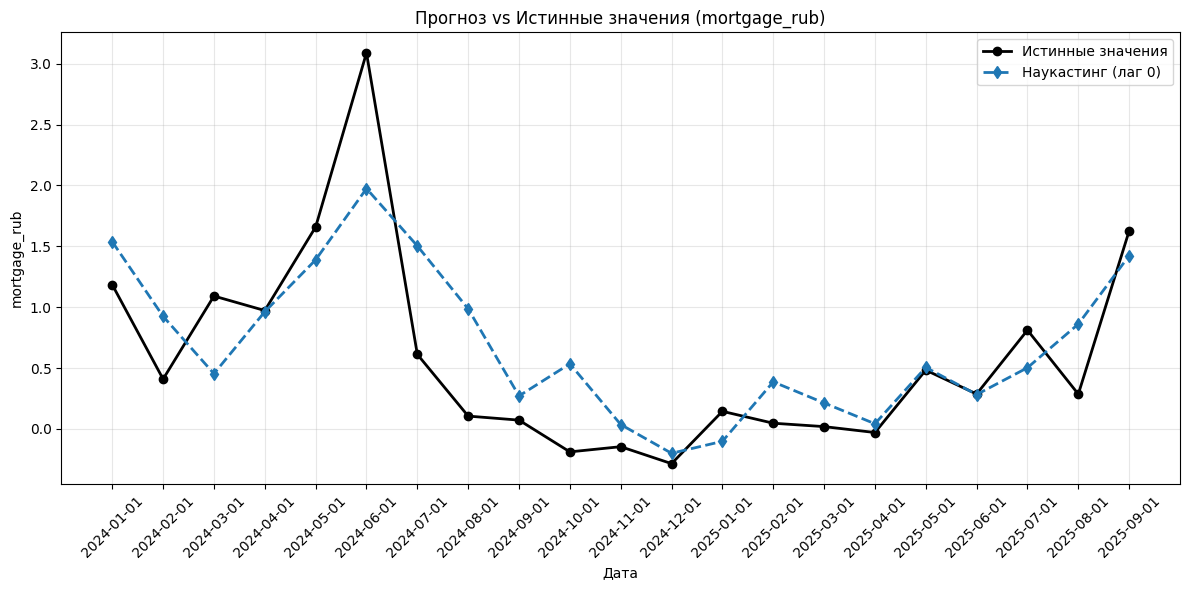

None


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

print(nowcasting_lstm(data_cut2, test_start_date, test_end_date, mortgage2, target_variable, mortgage_mean, mortgage_std, plot=1))

In [ ]:
target_variable = "potreb_rub"
data_cut3 = data[["date", target_variable, 'consump',
 'u_lvl',
 'gdp',
 'potrebh',
 'miacr',
 'ofz5',
 'credh_sr',
 'credh_lr',
 'usdrub',
 'urals',
 'rzp']]

columns = data_cut3.columns
metadata = pd.DataFrame(columns=['series', 'Frequency', 'months_lag'])

for col in data_cut3.columns:
    metadata = pd.concat([metadata, pd.DataFrame({'series': [col], 'Frequency': [12], "months_lag": [0]})], ignore_index=True)

# train and test dates
train_start_date = "2009-05-01"
train_end_date = "2023-12-01"
test_start_date = "2024-01-01"
test_end_date = "2025-09-01"

lags = list(range(0, 1))

train = data_cut3.loc[(data_cut3.date >= train_start_date) & (data_cut3.date <= train_end_date), :].reset_index(drop=True)
#test = data.loc[(data.date > train_end_date) & (data.date <= test_end_date), :].reset_index(drop=True)
test = data_cut3.loc[(data_cut3.date >= train_start_date) & (data_cut3.date <= test_end_date), :].reset_index(drop=True)

/tmp/ipython-input-2314231342.py:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  actuals = list(test.loc[test.date.isin(dates), target_variable].values)
/tmp/ipython-input-2314231342.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, tmp]).reset_index(drop=True)


  Vintage    RMSE     MAE
0       0  0.5182  0.3774


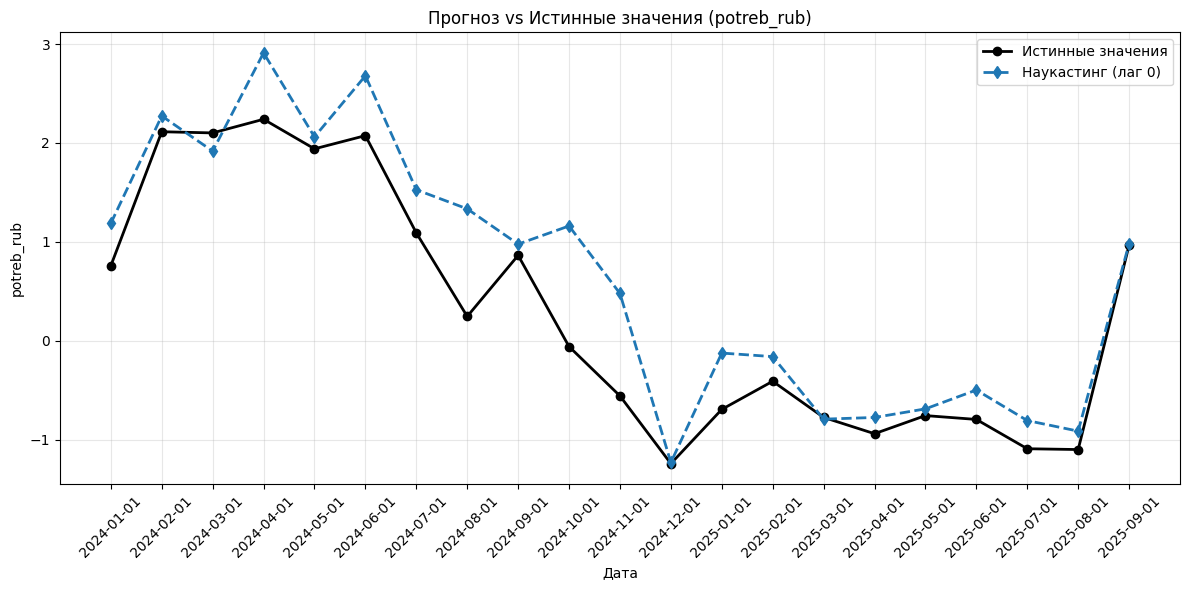

None


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

print(nowcasting_lstm(data_cut3, test_start_date, test_end_date, potreb2, target_variable, potreb_mean, potreb_std, plot=1))

# AR(1)


In [162]:
def rolling_ar1_forecast(
    series,
    train_size,
    n_steps=6,
    start_index=23,
    save_to_excel=True,
    filename='fcst_roll_ar1.xlsx',
    plot=True,
    title='AR(1) rolling forecast',
    ylim=None,
    xlim_back=12,
    mean=None, # credith_mean
    std=None, # credith_std
    inverse_transform=True, # делать ли обратную стандартизацию прогнозов
    metrics_in_original=False # RMSE в исходной шкале
):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.tsa.ar_model import AutoReg

    # Если series - numpy/list, приведём к pd.Series
    if not isinstance(series, pd.Series):
        series = pd.Series(series)

    # функции обратной стандартизации
    def inv(x):
        return np.asarray(x) * std + mean

    has_scaler = (mean is not None) and (std is not None) and inverse_transform

    fcst_roll = []
    fcst_roll_graph = []
    fcst_roll_hrz = []
    errors = [[] for _ in range(n_steps)]

    for i in range(train_size, len(series)):
        train = series.iloc[start_index:i]  # без шумной динамики до start_index
        last_actual = series.iloc[i - 1]

        if len(train) < 2:
            continue

        model = AutoReg(train, lags=1).fit()

        horizon = n_steps if (len(series) - i) >= n_steps else (len(series) - i)
        pred = model.forecast(steps=horizon)

        for h in range(len(pred)):
            actual = series.iloc[i: i + h + 1].values
            predicted = np.asarray(pred[: h + 1])

            if metrics_in_original and has_scaler:
                actual = inv(actual)
                predicted = inv(predicted)

            errors[h].append(np.mean((actual - predicted) ** 2))

        pred_arr = np.asarray(pred)

        if has_scaler:
            pred_save = inv(pred_arr)
            last_actual_save = float(inv([last_actual])[0])
        else:
            pred_save = pred_arr
            last_actual_save = float(last_actual)

        fcst_roll.append(pred_save.tolist())
        fcst_roll_hrz.append(len(pred_save))

        # для графика: последняя фактическая + прогноз
        full_path = np.concatenate([[last_actual_save], np.asarray(pred_save)]).tolist()
        fcst_roll_graph.append(full_path)

    # --- RMSE / NRMSE ---
    rmse_hrz = []
    nrmse_hrz = []

    # std для нормировки NRMSE
    if metrics_in_original and has_scaler:
        test_std = np.std(inv(series.iloc[train_size:].values)) if train_size < len(series) else np.std(inv(series.values))
    else:
        test_std = np.std(series.iloc[train_size:]) if train_size < len(series) else np.std(series)

    for h, error in enumerate(errors):
        if error:
            rmse = np.mean(np.sqrt(error))
            rmse_hrz.append(rmse)
            nrmse_hrz.append(rmse / test_std if test_std != 0 else np.nan)
        else:
            rmse_hrz.append(np.nan)
            nrmse_hrz.append(np.nan)

    df_fcst_roll = pd.DataFrame(fcst_roll)
    if not df_fcst_roll.empty:
        df_fcst_roll = df_fcst_roll.T

    if save_to_excel and not df_fcst_roll.empty:
        df_fcst_roll.to_excel(filename, index=False)

    print('\nNRMSE по горизонтам прогноза:')
    for h, nrmse in enumerate(nrmse_hrz):
        print(f'Горизонт {h+1}: {nrmse:.4f}')

    # --- график ---
    if plot and len(fcst_roll_graph) > 0:
        plt.figure(figsize=(10, 5))

        if has_scaler:
            series_plot = inv(series.values)  # исходная шкала
        else:
            series_plot = series.values

        plt.plot(series_plot, label='Original Series', color='black', linewidth=2)

        step = 1
        for i, (fcst, hrz) in enumerate(zip(fcst_roll_graph, fcst_roll_hrz)):
            if i % step != 0:
                continue
            start_idx = train_size + i
            x_forecast = range(start_idx - 1, start_idx + hrz)
            plt.plot(x_forecast, fcst, linewidth=1, alpha=0.5)

        plt.axvline(x=train_size - 1, color='black', linestyle='--', linewidth=2, label='Train / Test split')

        plt.xlim(train_size - xlim_back, len(series))

        y_min, y_max = -1, 3
        margin = 0.05 * (y_max - y_min) if y_max > y_min else 0.1

        plt.ylim(y_min - margin, y_max + margin)
        plt.xlabel('Время')
        plt.ylabel('Значение (исходная шкала)' if has_scaler else 'Значение')
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    return {
        'forecasts': fcst_roll,
        'forecasts_graph': fcst_roll_graph,
        'forecasts_horizon': fcst_roll_hrz,
        'rmse': rmse_hrz,
        'nrmse': nrmse_hrz,
        'errors': errors,
        'df_forecasts': df_fcst_roll
    }


In [163]:
credith_sec = data_cr["credith_sec"]
mortgage = data_mor["mortgage_rub"]
potreb = data_po["potreb_rub"]

In [ ]:
print(credith_sec)

0      0.000000
1      0.976473
2     -0.486701
3     -0.024642
4      0.195992
         ...   
279   -0.942698
280   -0.905289
281   -0.965293
282   -0.880931
283   -0.946366
Name: credith_sec, Length: 284, dtype: float64



NRMSE по горизонтам прогноза:
Горизонт 1: 0.3689
Горизонт 2: 0.4799
Горизонт 3: 0.5752
Горизонт 4: 0.6557
Горизонт 5: 0.7312
Горизонт 6: 0.7861


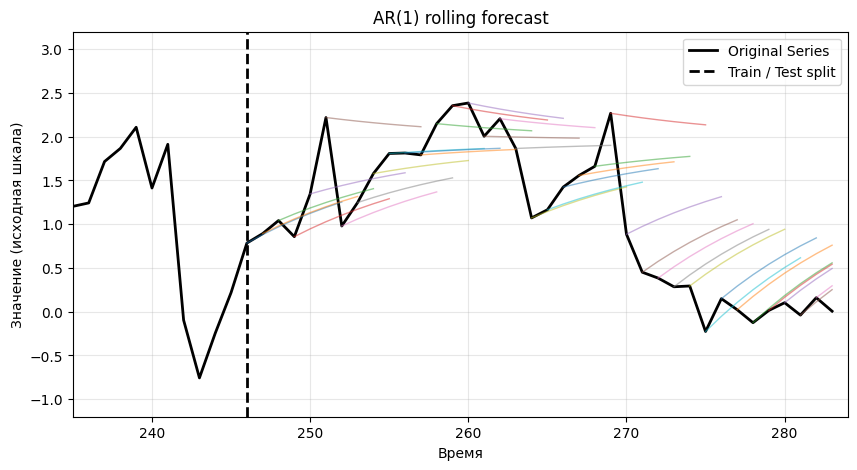

In [ ]:
results_cr_ar = rolling_ar1_forecast(
    series=credith_sec,
    train_size=247,  # размер обучающей выборки 251 - до дек22
    n_steps=6,
    start_index=23,  # без шумной динамики до 2004 года
    save_to_excel=True,
    filename='fcst_roll_credith_sec_ar1.xlsx',
    mean = credith_mean,
    std = credith_std
)


NRMSE по горизонтам прогноза:
Горизонт 1: 0.5645
Горизонт 2: 0.6905
Горизонт 3: 0.7734
Горизонт 4: 0.8502
Горизонт 5: 0.9107
Горизонт 6: 0.9561


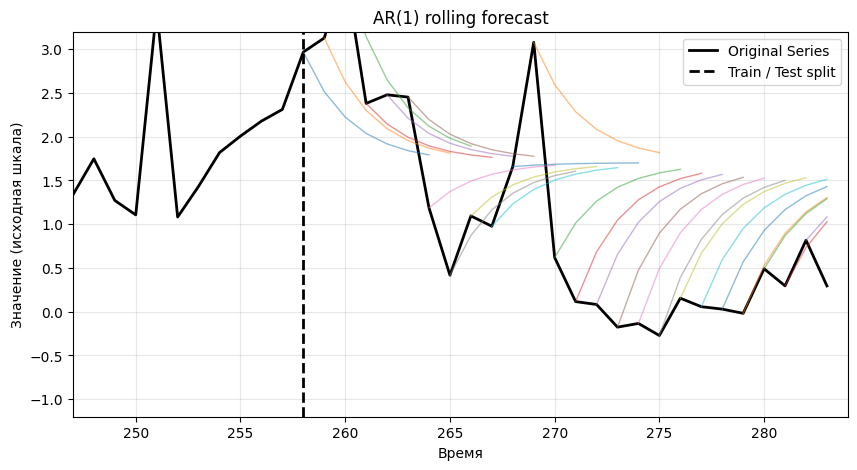

In [ ]:
results_mo_ar = rolling_ar1_forecast(
    series=mortgage,
    train_size=259,  # размер обучающей выборки 263 - до дек23
    n_steps=6,
    start_index=23,  # без шумной динамики до 2004 года
    save_to_excel=True,
    filename='fcst_roll_mortgage_ar1.xlsx',
    mean = mortgage_mean,
    std = mortgage_std
)


NRMSE по горизонтам прогноза:
Горизонт 1: 0.3403
Горизонт 2: 0.4392
Горизонт 3: 0.5244
Горизонт 4: 0.6048
Горизонт 5: 0.6883
Горизонт 6: 0.7626


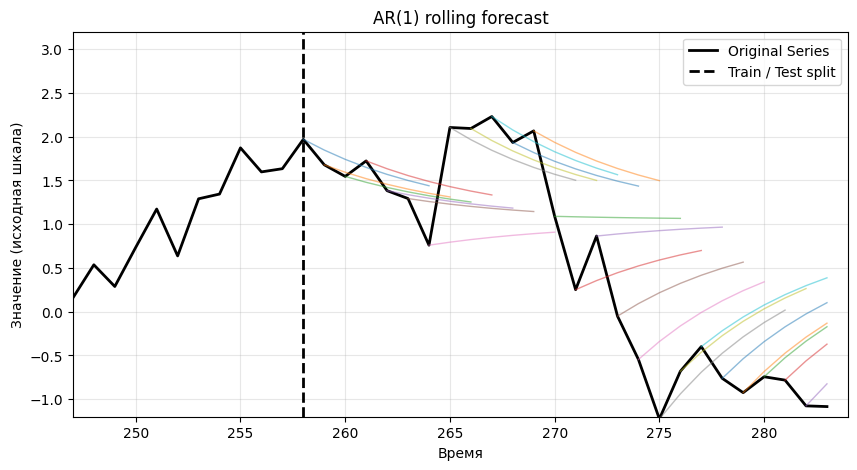

In [ ]:
results_po_ar = rolling_ar1_forecast(
    series=potreb,
    train_size=259,  # размер обучающей выборки 263 - до дек23
    n_steps=6,
    start_index=23,  # без шумной динамики до 2004 года
    save_to_excel=True,
    filename='fcst_roll_potreb_ar1.xlsx',
    mean = potreb_mean,
    std = potreb_std
)

# Тест Диболда – Мариано

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import t

def dm_test_df(
    df: pd.DataFrame,
    actual_col: str,
    pred1_col: str,
    pred2_col: str,
    h: int = 1,
    loss: str = "mse",
    nw_lags: int | None = None,
):


    x = df[[actual_col, pred1_col, pred2_col]].copy()
    x = x.dropna()
    a = x[actual_col].to_numpy(dtype=float)
    p1 = x[pred1_col].to_numpy(dtype=float)
    p2 = x[pred2_col].to_numpy(dtype=float)

    e1 = a - p1
    e2 = a - p2

    if loss.lower() == "mse":
        d = (e1 ** 2) - (e2 ** 2)
    elif loss.lower() == "mae":
        d = np.abs(e1) - np.abs(e2)

    T = len(d)
    mean_d = d.mean()

    if nw_lags is None:
        nw_lags = max(h - 1, 0)

    # autocovariance gamma_k
    def gamma_k(d, k):
        # sample autocovariance with denominator T
        return np.sum((d[k:] - mean_d) * (d[:-k] - mean_d)) / T if k > 0 else np.sum((d - mean_d) ** 2) / T

    gammas = [gamma_k(d, k) for k in range(nw_lags + 1)]

    # Newey–West with Bartlett weights
    V_d = gammas[0]
    for k in range(1, nw_lags + 1):
        weight = 1.0 - k / (nw_lags + 1)
        V_d += 2.0 * weight * gammas[k]
    V_d = V_d / T

    # защита от вырождения
    if V_d <= 0 or np.isclose(V_d, 0):
        return {
            "DM_stat": np.nan,
            "p_value": np.nan,
            "mean_d": mean_d,
            "V_d": V_d,
            "n_obs": T,
            "nw_lags": nw_lags,
            "note": "HAC variance is zero/non-positive; DM test undefined."
        }

    DM_stat = mean_d / np.sqrt(V_d)

    harvey_adj = np.sqrt((T + 1 - 2*h + (h*(h-1))/T) / T)
    DM_stat_adj = DM_stat * harvey_adj

    p_value = 2.0 * t.cdf(-abs(DM_stat_adj), df=T - 1)

    return {
        "DM_stat": DM_stat_adj,
        "p_value": p_value,
        "mean_d": mean_d,
        "V_d": V_d,
        "n_obs": T,
        "nw_lags": nw_lags,
        "loss": loss.lower()
    }


**CREDITH**

In [ ]:
bm = pd.read_excel("credith_forecast.xlsx")

# bm = bm[bm['Dates'] >= '2023-01-01']

actuals_cr = bm["Credith_real"]
pred_credith_1 = bm["Credith_2_1"]
pred_credith_2 = bm["Credith_2_2"]
pred_credith_3 = bm["Credith_2_3"]
pred_credith_4 = bm["Credith_2_4"]
pred_credith_5 = bm["Credith_2_5"]
pred_credith_6 = bm["Credith_2_6"]
pred_ar_credith_1 = bm["AR1"]
pred_ar_credith_2 = bm["AR2"]
pred_ar_credith_3 = bm["AR3"]
pred_ar_credith_4 = bm["AR4"]
pred_ar_credith_5 = bm["AR5"]
pred_ar_credith_6 = bm["AR6"]

pred_credith = [pred_credith_1, pred_credith_2, pred_credith_3,
                pred_credith_4, pred_credith_5, pred_credith_6]

pred_ar_credith = [pred_ar_credith_1, pred_ar_credith_2, pred_ar_credith_3,
           pred_ar_credith_4, pred_ar_credith_5, pred_ar_credith_6]

lags = [-1]

In [ ]:
res = dm_test_df(
    df=bm,
    actual_col="Credith_real",
    pred1_col="Credith_2_4",
    pred2_col="AR4",
    h=1,
    loss="mse"
)

In [ ]:
res

{'DM_stat': nan,
 'p_value': nan,
 'mean_d': nan,
 'V_d': nan,
 'n_obs': 32,
 'nw_lags': 0,
 'loss': 'rmse'}

**MORTGAGE**

In [ ]:
bm_mo = pd.read_excel("mo_po_forecast.xlsx")

#bm_mo = bm_mo[bm_mo['Dates'] >= '2024-06-01']

actuals_mo = bm_mo["Mortgage_real"]
pred_mortgage_1 = bm_mo["Mortgage_1_1"]
pred_mortgage_2 = bm_mo["Mortgage_1_2"]
pred_mortgage_3 = bm_mo["Mortgage_1_3"]
pred_mortgage_4 = bm_mo["Mortgage_1_4"]
pred_mortgage_5 = bm_mo["Mortgage_1_5"]
pred_mortgage_6 = bm_mo["Mortgage_1_6"]
pred_ar_mortgage_1 = bm_mo["AR1_m"]
pred_ar_mortgage_2 = bm_mo["AR2_m"]
pred_ar_mortgage_3 = bm_mo["AR3_m"]
pred_ar_mortgage_4 = bm_mo["AR4_m"]
pred_ar_mortgage_5 = bm_mo["AR5_m"]
pred_ar_mortgage_6 = bm_mo["AR6_m"]

pred_mortgage = [pred_mortgage_1, pred_mortgage_2, pred_mortgage_3,
                pred_mortgage_4, pred_mortgage_5, pred_mortgage_6]

pred_ar_mortgage = [pred_ar_mortgage_1, pred_ar_mortgage_2, pred_ar_mortgage_3,
           pred_ar_mortgage_4, pred_ar_mortgage_5, pred_ar_mortgage_6]

In [ ]:
res = dm_test_df(
    df=bm_mo,
    actual_col="Mortgage_real",
    pred1_col="Mortgage_1_6",
    pred2_col="AR6_m",
    h=1,
    loss="mse"
)

In [ ]:
res

{'DM_stat': 1.6636958718237185,
 'p_value': 0.11257999946802426,
 'mean_d': 1.7692592863281547,
 'V_d': 1.0743819288125813,
 'n_obs': 20,
 'nw_lags': 0,
 'loss': 'mse'}

**POTREB**

In [ ]:
bm_po = pd.read_excel("mo_po_forecast.xlsx")

#bm_po = bm_po[bm_po['Dates'] >= '2024-06-01']

actuals_po = bm_po["Potreb_real"]
pred_potreb_1 = bm_po["Potreb_3_1"]
pred_potreb_2 = bm_po["Potreb_3_2"]
pred_potreb_3 = bm_po["Potreb_3_3"]
pred_potreb_4 = bm_po["Potreb_3_4"]
pred_potreb_5 = bm_po["Potreb_3_5"]
pred_potreb_6 = bm_po["Potreb_3_6"]
pred_ar_potreb_1 = bm_po["AR1_p"]
pred_ar_potreb_2 = bm_po["AR2_p"]
pred_ar_potreb_3 = bm_po["AR3_p"]
pred_ar_potreb_4 = bm_po["AR4_p"]
pred_ar_potreb_5 = bm_po["AR5_p"]
pred_ar_potreb_6 = bm_po["AR6_p"]

pred_potreb = [pred_potreb_1, pred_potreb_2, pred_potreb_3,
                pred_potreb_4, pred_potreb_5, pred_potreb_6]

pred_ar_potreb = [pred_ar_potreb_1, pred_ar_potreb_2, pred_ar_potreb_3,
           pred_ar_potreb_4, pred_ar_potreb_5, pred_ar_potreb_6]

In [ ]:
res = dm_test_df(
    df=bm_po,
    actual_col="Potreb_real",
    pred1_col="Potreb_3_6",
    pred2_col="AR6_p",
    h=1,
    loss="mse"
)

In [ ]:
res

{'DM_stat': -3.642894532468156,
 'p_value': 0.0017309181106161624,
 'mean_d': -0.7144868469422172,
 'V_d': 0.036544235919281076,
 'n_obs': 20,
 'nw_lags': 0,
 'loss': 'mse'}

# AR vs LSTM

In [161]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_actual_vs_forecasts(
    df,
    date_col,
    actual_col,
    forecast1_col,
    forecast2_col,
    title="Actual vs Forecasts",
    figsize=(12, 5),
    start_date=None
):

    data = df.copy()
    data[date_col] = pd.to_datetime(data[date_col])
    if start_date is not None:
        data = data[data[date_col] >= start_date]

    plt.figure(figsize=figsize)

    plt.plot(
        data[date_col],
        data[actual_col],
        label="Actual",
        color="black",
        linewidth=2
    )

    # прогноз 1
    plt.plot(
        data[date_col],
        data[forecast1_col],
        label="LSTM",
        color="tab:blue",
        linestyle="--",
        linewidth=2
    )

    # прогноз 2
    plt.plot(
        data[date_col],
        data[forecast2_col],
        label="AR(1)",
        color="tab:red",
        linestyle=":",
        linewidth=2
    )

    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)

    all_y = pd.concat([
        data[actual_col],
        data[forecast1_col],
        data[forecast2_col]
    ])
    y_min, y_max = all_y.min(), all_y.max()
    margin = 0.05 * (y_max - y_min)
    plt.ylim(y_min - margin, y_max + margin)

    plt.tight_layout()
    plt.show()

In [ ]:
bm.head()

Dates  Credith_real  Credith_1_1  Credith_1_2  Credith_1_3  \
0  2023-01-01      0.979426     0.806963     0.570401     0.724404   
1  2023-02-01      1.247600     1.106376     1.110157     0.923278   
2  2023-03-01      1.579014     1.448549     1.387938     1.145541   
3  2023-04-01      1.808590     1.764560     1.572562     1.500256   
4  2023-05-01      1.813696     1.489372     1.976897     1.859001   

   Credith_1_4  Credith_1_5  Credith_1_6  Credith_2_1  Credith_2_2  ...  \
0     2.125056     2.146054     2.122217     1.413343     1.366157  ...   
1     0.746987     2.225114     2.537558     1.250560     1.367056  ...   
2     0.803718     0.432329     2.146809     1.534243     1.549081  ...   
3     1.505836     1.445818     1.262189     1.861506     1.887956  ...   
4     1.813994     1.068685     0.835074     1.881974     1.821237  ...   

   Credith_3_3  Credith_3_4  Credith_3_5  Credith_3_6       AR1       AR2  \
0     1.817527     2.228441     2.315563     2.255186  2.197649  1.441709   
1     1.319224     1.461447     1.802985     1.783335  1.059940  2.177820   
2     1.874838     1.829406     1.421180     2.039154  1.305878  1.133470   
3     1.978178     2.305968     2.538699     2.009219  1.609800  1.359088   
4     1.479518     1.404620     1.606528     1.413160  1.820247  1.637900   

        AR3       AR4       AR5       AR6  
0  1.103325  1.305634  1.261490  1.253657  
1  1.483279  1.171645  1.358085  1.317377  
2  2.159709  1.521275  1.234129  1.406040  
3  1.200622  2.143168  1.556005  1.291276  
4  1.407670  1.261950  2.128060  1.587749  

[5 rows x 26 columns]

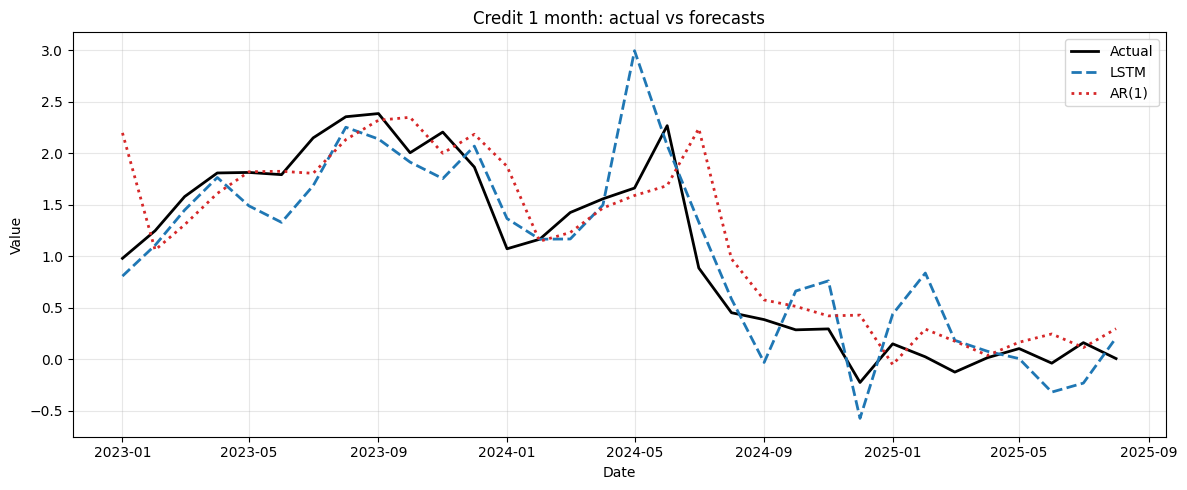

In [164]:
plot_actual_vs_forecasts(
    df=bm,
    date_col="Dates",
    actual_col="Credith_real",
    forecast1_col="Credith_1_1",
    forecast2_col="AR1",
    title="Credit 1 month: actual vs forecasts",
    start_date="2023-01-01"
)


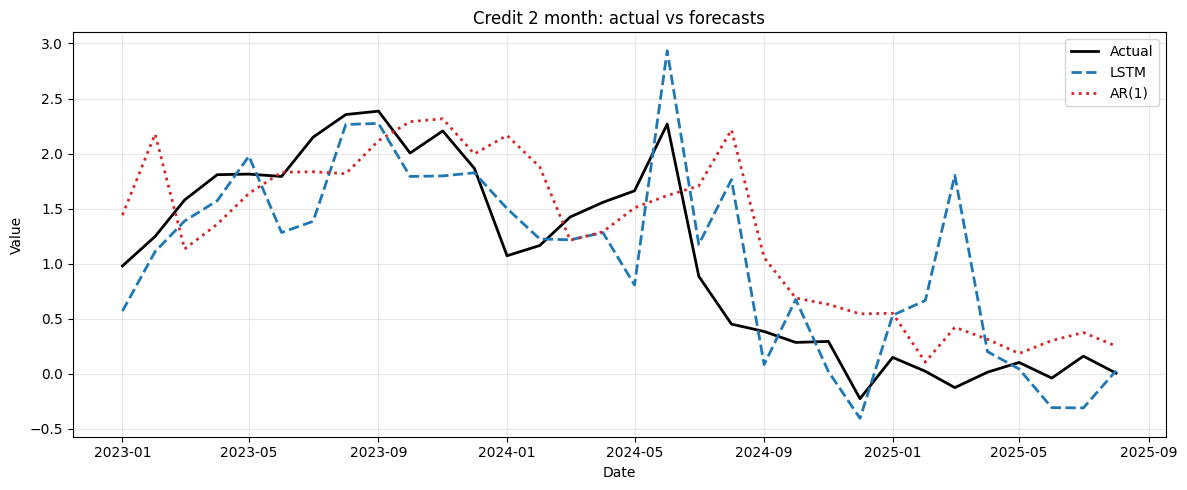

In [165]:
plot_actual_vs_forecasts(
    df=bm,
    date_col="Dates",
    actual_col="Credith_real",
    forecast1_col="Credith_1_2",
    forecast2_col="AR2",
    title="Credit 2 month: actual vs forecasts",
    start_date="2023-01-01"
)


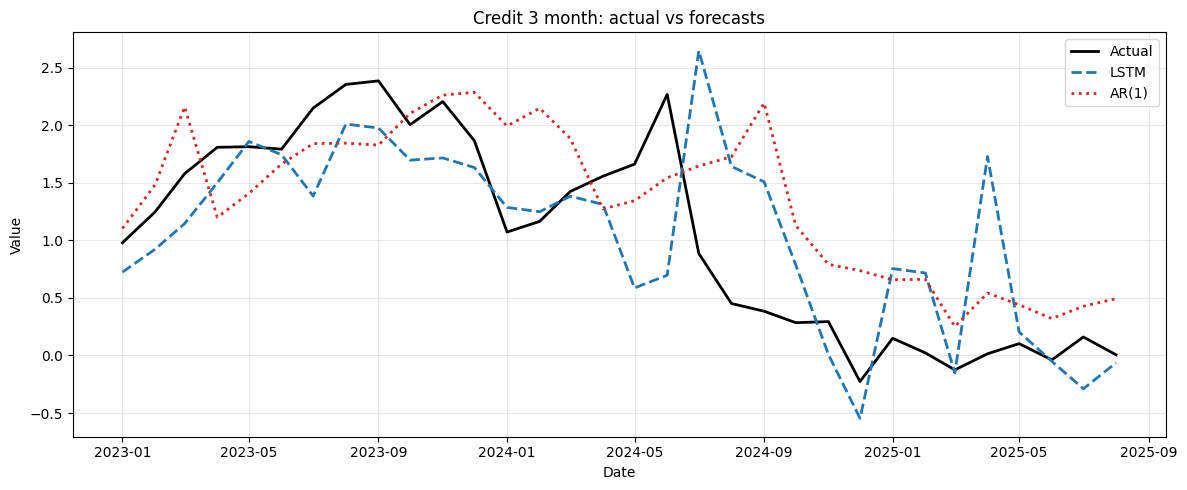

In [166]:
plot_actual_vs_forecasts(
    df=bm,
    date_col="Dates",
    actual_col="Credith_real",
    forecast1_col="Credith_1_3",
    forecast2_col="AR3",
    title="Credit 3 month: actual vs forecasts",
    start_date="2023-01-01"
)


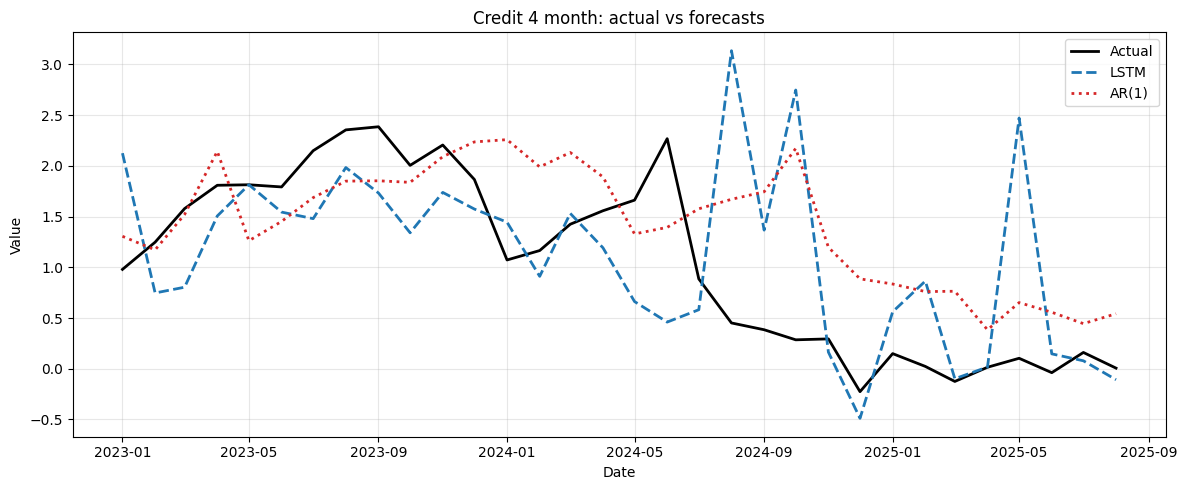

In [167]:
plot_actual_vs_forecasts(
    df=bm,
    date_col="Dates",
    actual_col="Credith_real",
    forecast1_col="Credith_1_4",
    forecast2_col="AR4",
    title="Credit 4 month: actual vs forecasts",
    start_date="2023-01-01"
)


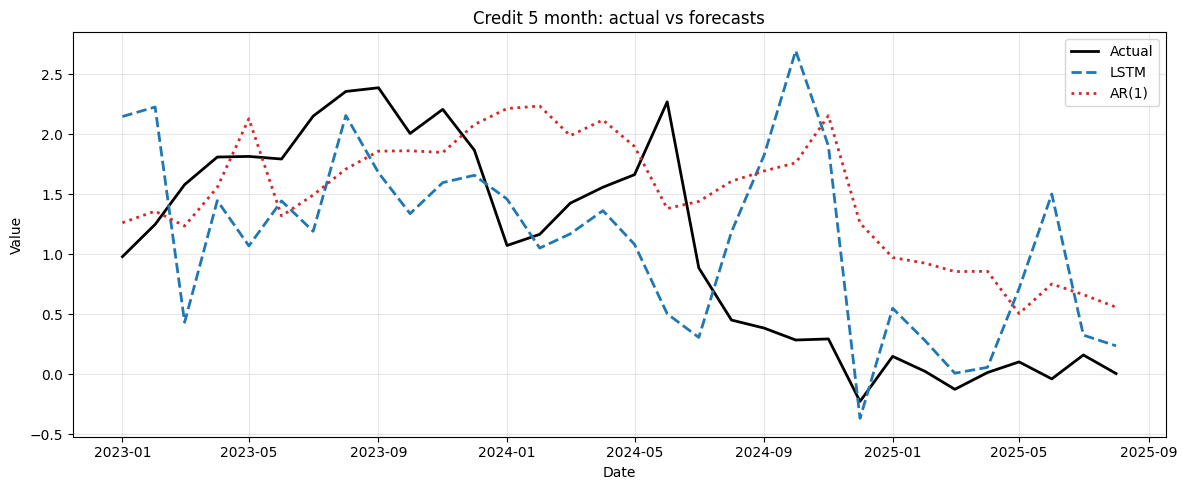

In [168]:
plot_actual_vs_forecasts(
    df=bm,
    date_col="Dates",
    actual_col="Credith_real",
    forecast1_col="Credith_1_5",
    forecast2_col="AR5",
    title="Credit 5 month: actual vs forecasts",
    start_date="2023-01-01"
)


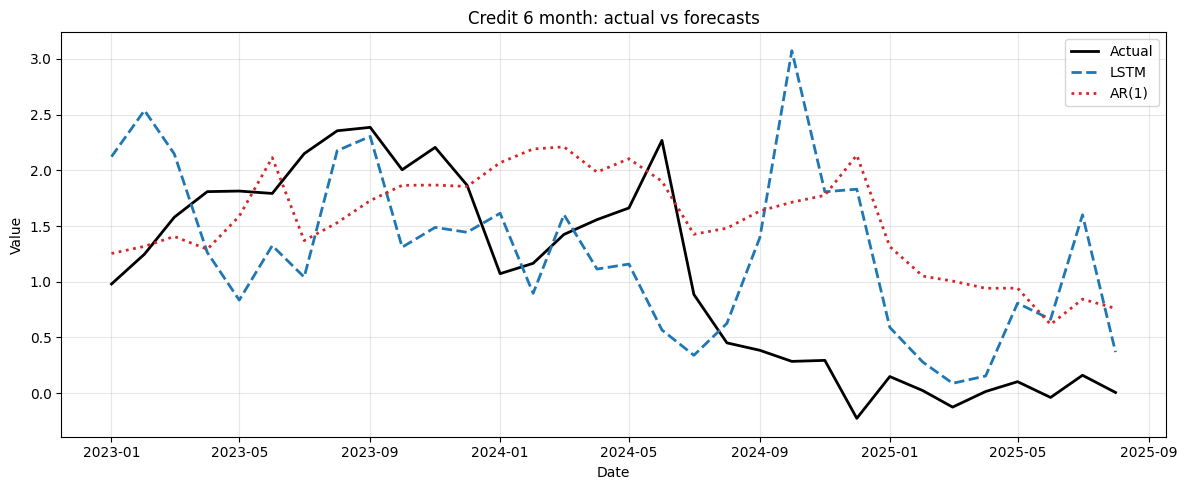

In [169]:
plot_actual_vs_forecasts(
    df=bm,
    date_col="Dates",
    actual_col="Credith_real",
    forecast1_col="Credith_1_6",
    forecast2_col="AR6",
    title="Credit 6 month: actual vs forecasts",
    start_date="2023-01-01"
)


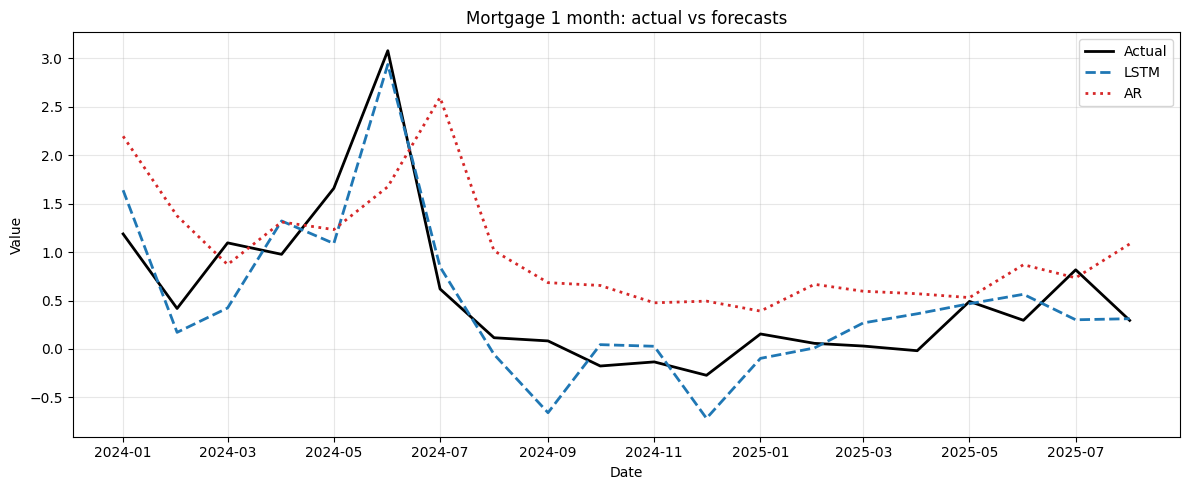

In [ ]:
plot_actual_vs_forecasts(
    df=bm_mo,
    date_col="Dates",
    actual_col="Mortgage_real",
    forecast1_col="Mortgage_1_1",
    forecast2_col="AR1_m",
    title="Mortgage 1 month: actual vs forecasts",
    start_date="2024-01-01"
)


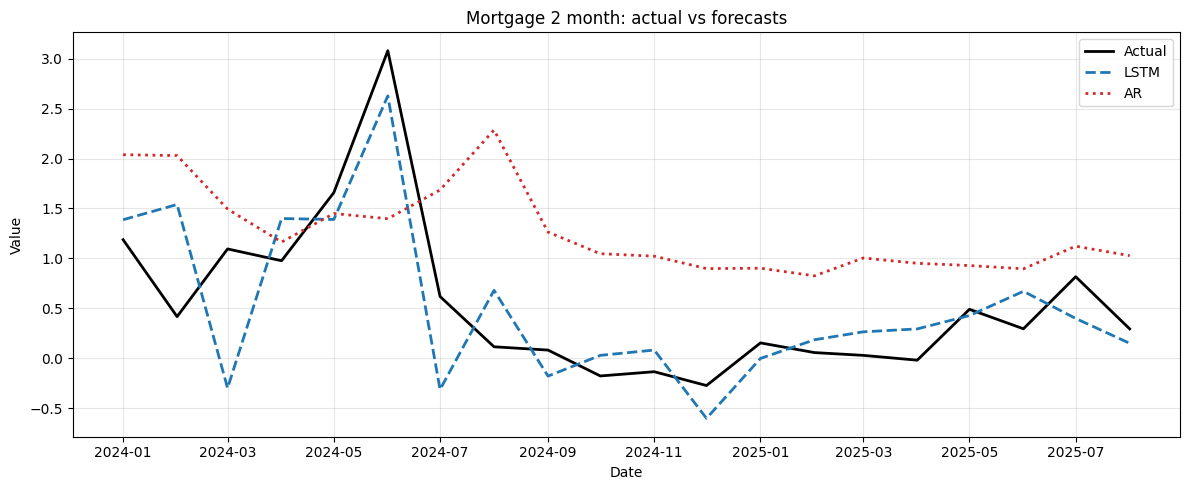

In [ ]:
plot_actual_vs_forecasts(
    df=bm_mo,
    date_col="Dates",
    actual_col="Mortgage_real",
    forecast1_col="Mortgage_1_2",
    forecast2_col="AR2_m",
    title="Mortgage 2 month: actual vs forecasts",
    start_date="2024-01-01"
)

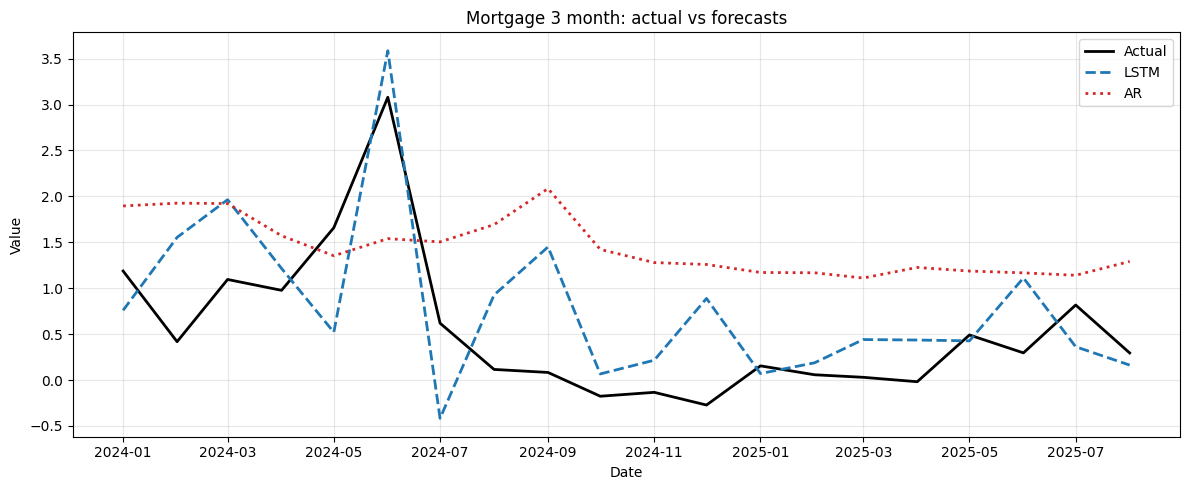

In [ ]:
plot_actual_vs_forecasts(
    df=bm_mo,
    date_col="Dates",
    actual_col="Mortgage_real",
    forecast1_col="Mortgage_1_3",
    forecast2_col="AR3_m",
    title="Mortgage 3 month: actual vs forecasts",
    start_date="2024-01-01"
)

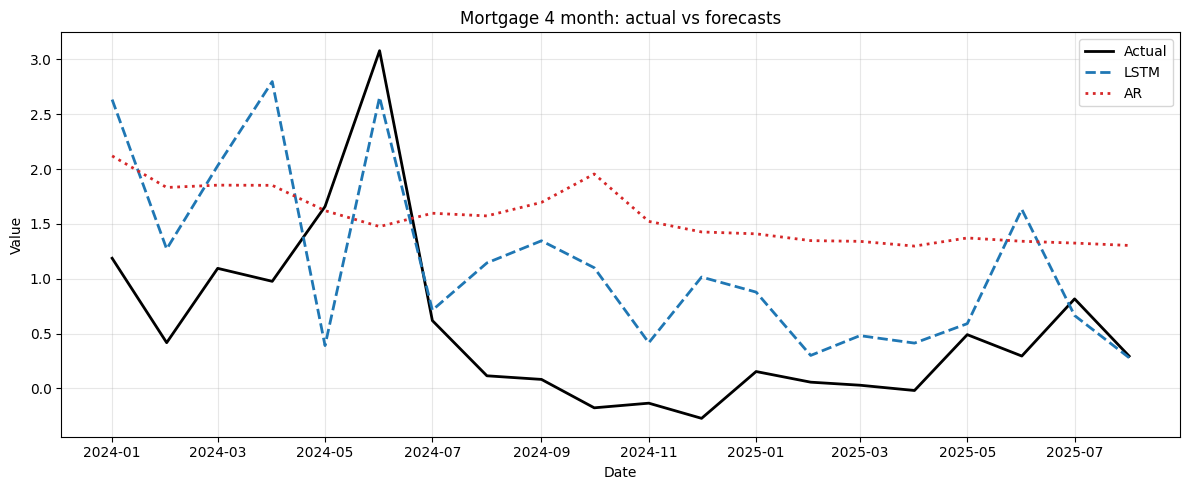

In [ ]:
plot_actual_vs_forecasts(
    df=bm_mo,
    date_col="Dates",
    actual_col="Mortgage_real",
    forecast1_col="Mortgage_1_4",
    forecast2_col="AR4_m",
    title="Mortgage 4 month: actual vs forecasts",
    start_date="2024-01-01"
)

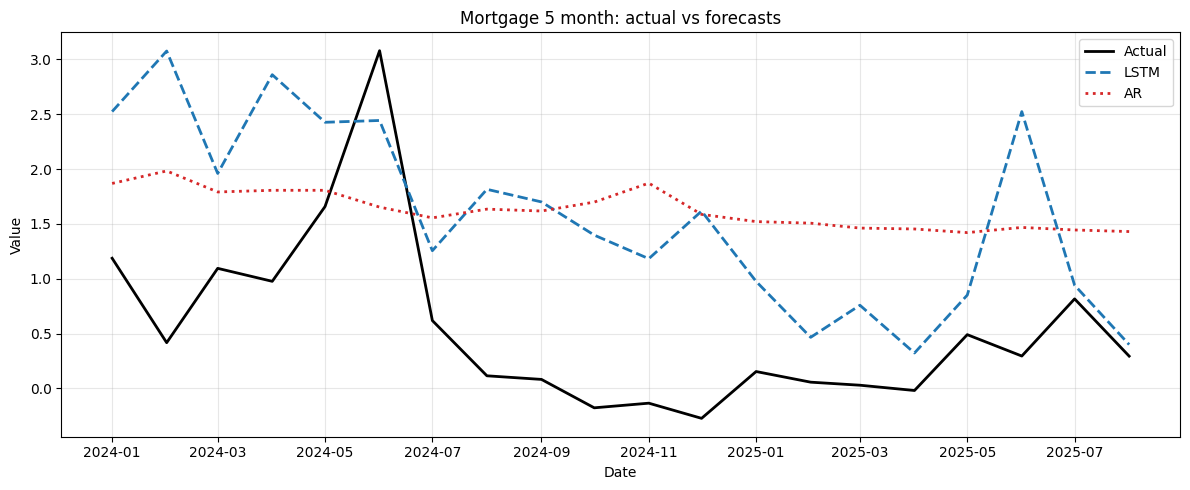

In [ ]:
plot_actual_vs_forecasts(
    df=bm_mo,
    date_col="Dates",
    actual_col="Mortgage_real",
    forecast1_col="Mortgage_1_5",
    forecast2_col="AR5_m",
    title="Mortgage 5 month: actual vs forecasts",
    start_date="2024-01-01"
)

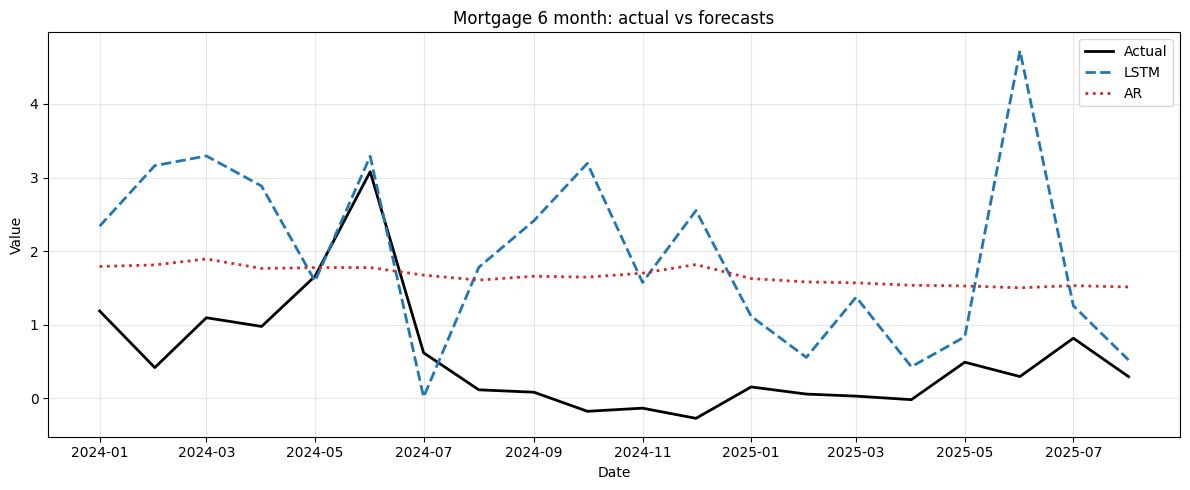

In [ ]:
plot_actual_vs_forecasts(
    df=bm_mo,
    date_col="Dates",
    actual_col="Mortgage_real",
    forecast1_col="Mortgage_1_6",
    forecast2_col="AR6_m",
    title="Mortgage 6 month: actual vs forecasts",
    start_date="2024-01-01"
)

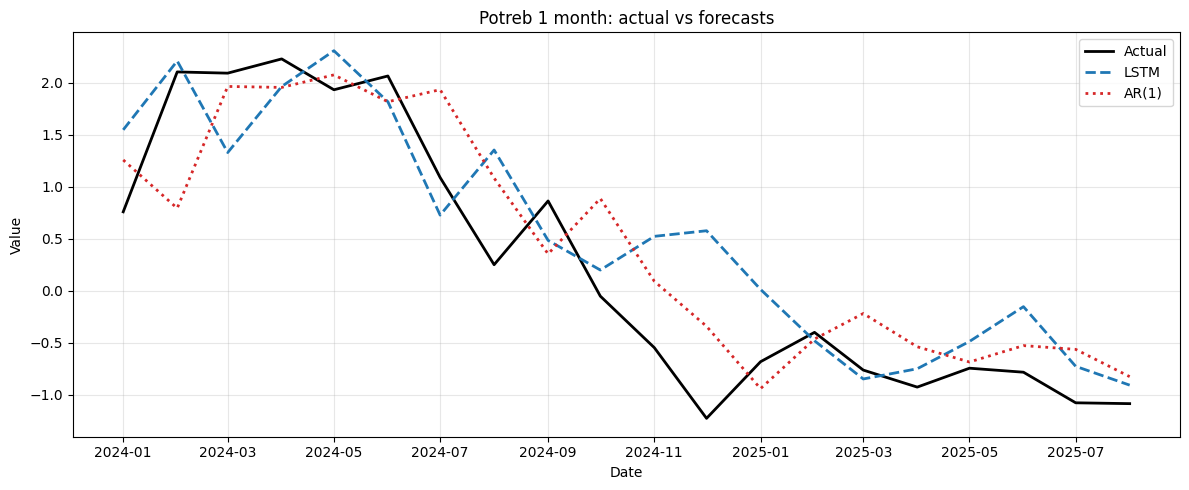

In [176]:
plot_actual_vs_forecasts(
    df=bm_po,
    date_col="Dates",
    actual_col="Potreb_real",
    forecast1_col="Potreb_3_1",
    forecast2_col="AR1_p",
    title="Potreb 1 month: actual vs forecasts",
    start_date="2024-01-01"
)


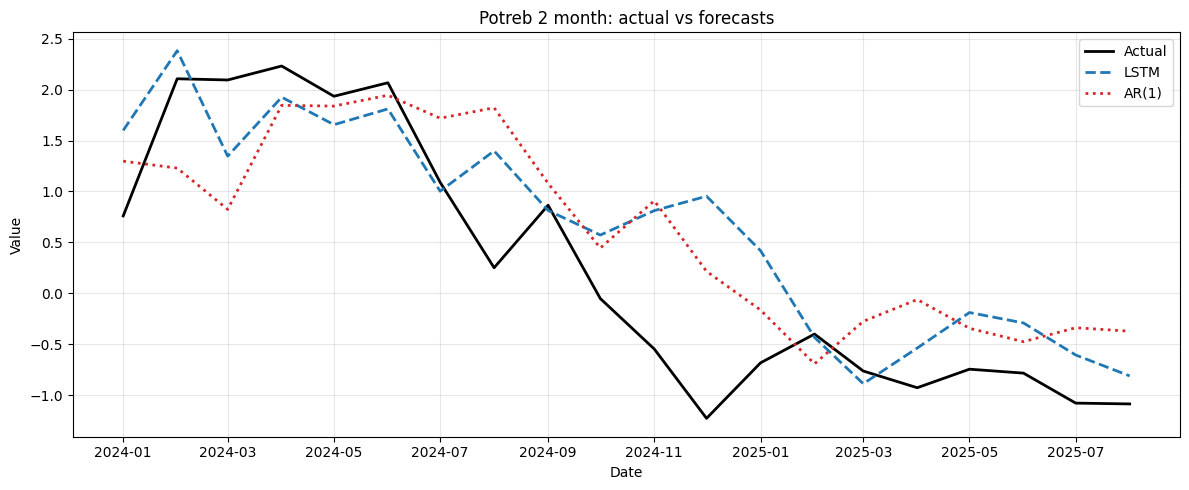

In [177]:
plot_actual_vs_forecasts(
    df=bm_po,
    date_col="Dates",
    actual_col="Potreb_real",
    forecast1_col="Potreb_3_2",
    forecast2_col="AR2_p",
    title="Potreb 2 month: actual vs forecasts",
    start_date="2024-01-01"
)


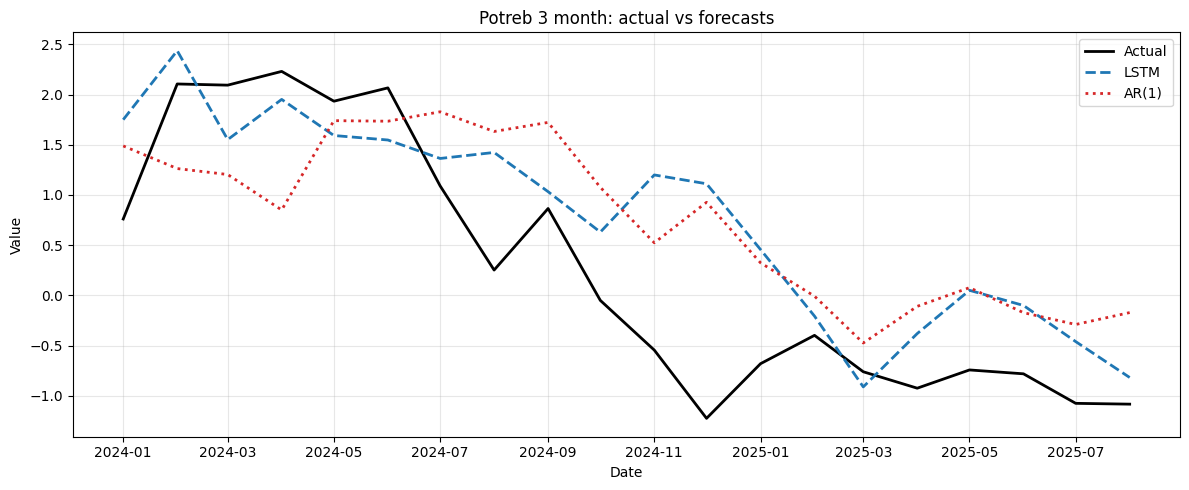

In [178]:
plot_actual_vs_forecasts(
    df=bm_po,
    date_col="Dates",
    actual_col="Potreb_real",
    forecast1_col="Potreb_3_3",
    forecast2_col="AR3_p",
    title="Potreb 3 month: actual vs forecasts",
    start_date="2024-01-01"
)


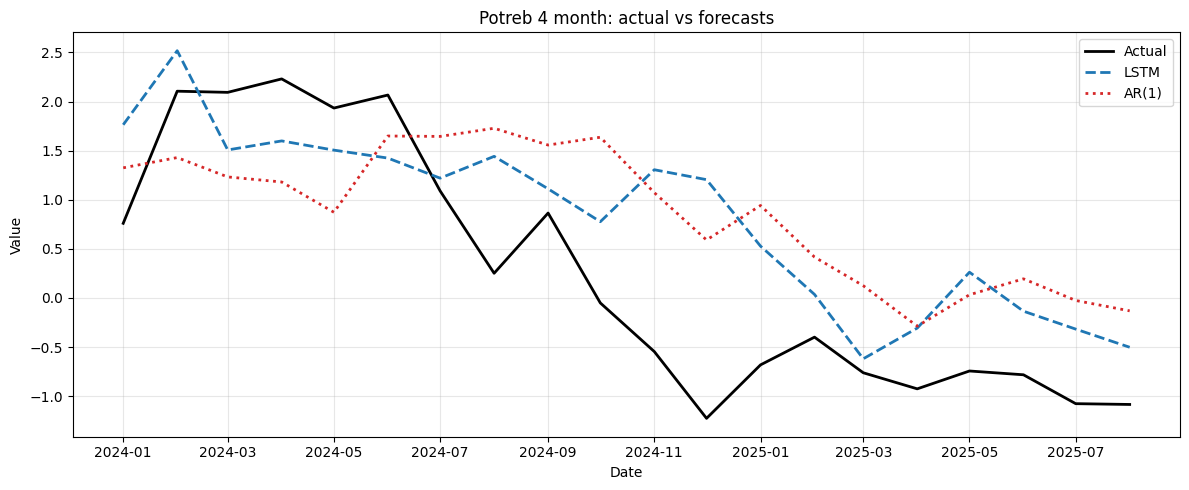

In [179]:
plot_actual_vs_forecasts(
    df=bm_po,
    date_col="Dates",
    actual_col="Potreb_real",
    forecast1_col="Potreb_3_4",
    forecast2_col="AR4_p",
    title="Potreb 4 month: actual vs forecasts",
    start_date="2024-01-01"
)


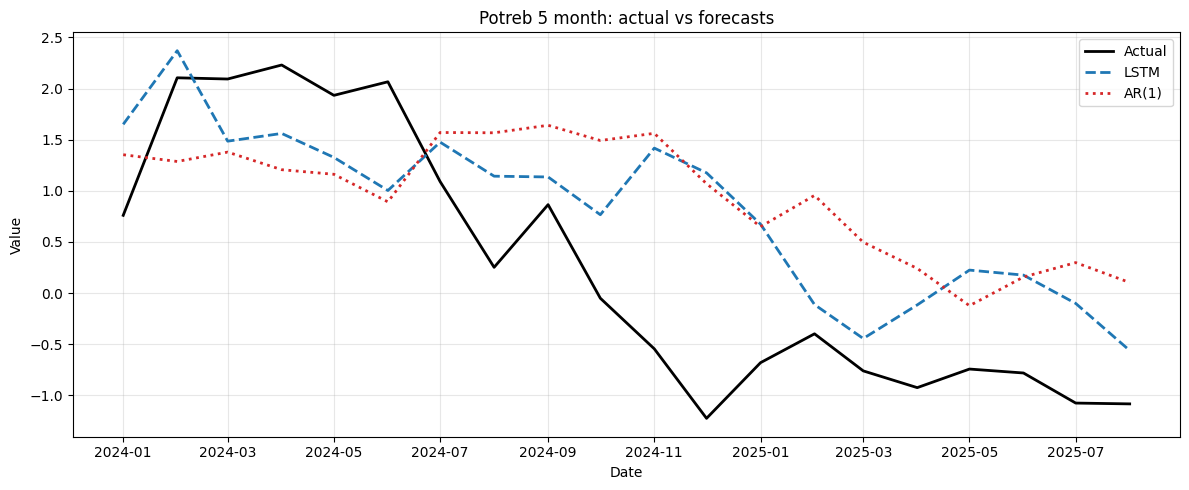

In [180]:
plot_actual_vs_forecasts(
    df=bm_po,
    date_col="Dates",
    actual_col="Potreb_real",
    forecast1_col="Potreb_3_5",
    forecast2_col="AR5_p",
    title="Potreb 5 month: actual vs forecasts",
    start_date="2024-01-01"
)


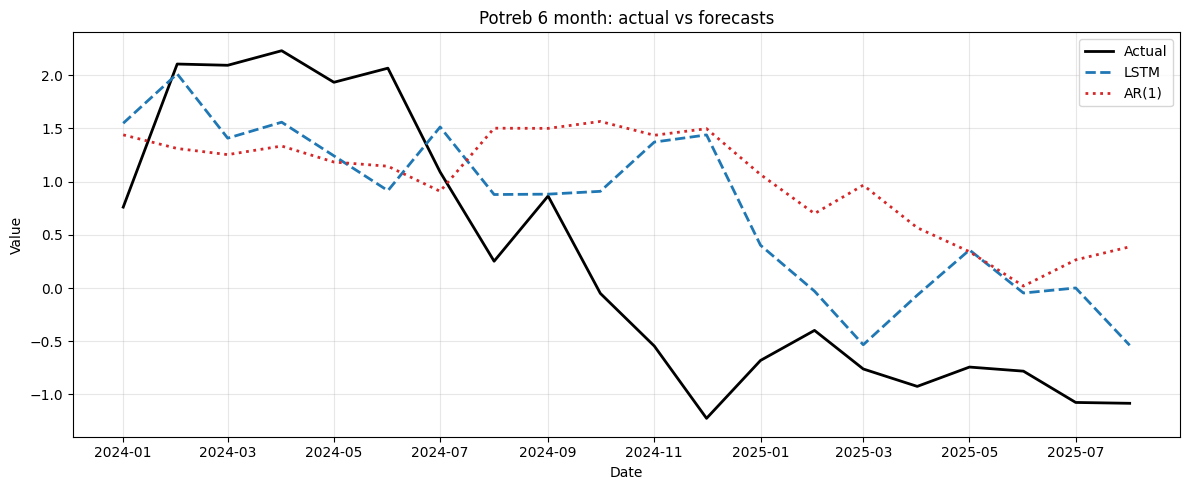

In [181]:
plot_actual_vs_forecasts(
    df=bm_po,
    date_col="Dates",
    actual_col="Potreb_real",
    forecast1_col="Potreb_3_6",
    forecast2_col="AR6_p",
    title="Potreb 6 month: actual vs forecasts",
    start_date="2024-01-01"
)
